In [2]:
import csv
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.graph_objects as go
%matplotlib inline

# Harmonisation Script

In [3]:
# Variables
filename = '../qcat-api-scripts/output/tech.csv'
target_costs_comparison = 2020
plt.rcParams['figure.figsize'] = [12, 8]

cashflow_length = 10 # 10 years


In [4]:
# CSV Reading and dataframe creation
@staticmethod
def _get_csv_options() -> dict:
    """Options for CSV writing and reading"""
    return {'delimiter': ';', 'quoting': csv.QUOTE_NONNUMERIC}

rows = []
with open(filename, newline='', encoding='utf-8') as csv_file:
    reader = csv.DictReader(csv_file, dialect='excel', delimiter=';', quoting=csv.QUOTE_NONNUMERIC)
    for row in reader:
        rows.append(row)

df = pd.DataFrame(rows)
df.index = df['code'].str.lstrip('technologies_')

df.replace('', np.NaN, inplace=True)
df = df[~df.index.duplicated(keep='first')]

## Calculating the year costs were documented

The first task in harmonizing the data is to extract the year that the costs were documented in. This data is taken from a number of fields and is not consistent across the dataset. In order of preference we have taken the values from the following fields:
- 1_3_date_documentation
- 7_1_date_documentation
- 2_6_tech_implementation_year
- 2_6_tech_implementation_decades

There are also a number of formatting issues with the input data which also requires cleaning before the calculated implementation year can be used in later calculations.

The reason for not using the *2_6_tech_implementation_decades* as the primary source for the year is that a significant proportion of the questionnaires have been completed retrospectively and although the technology may have been introduced decades ago the pricing has been completed with recent figures.

Text(0.5, 1.0, 'Costs Recorded Date Distribution')

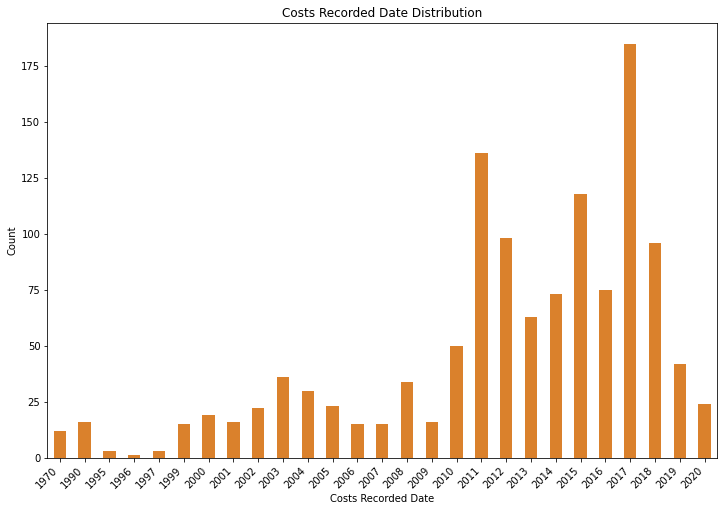

In [5]:
# Year cleaning
df.at['4123', '2_6_tech_implementation_year'] = "1987" # 87
df.at['3673', '2_6_tech_implementation_year'] = "1998" # 20 (20years from created date)
df.at['3683', '2_6_tech_implementation_year'] = "2016" # 2 (2years from created date)

df.at['1761', '1_3_date_documentation'] = '2015'
df.at['3677', '1_3_date_documentation'] = '2018'
df.at['4252', '1_3_date_documentation'] = '2018'
df.at['1930', '1_3_date_documentation'] = '2017'
df.at['5819', '1_3_date_documentation'] = '2020'
df.at['4285', '1_3_date_documentation'] = '2018'
df.at['4328', '1_3_date_documentation'] = '2013'

df.at['1528', '7_1_date_documentation'] = "01/01/2012" # 2012/2018
df.at['3670', '7_1_date_documentation'] = "01/01/2015" # 20152017
df.at['3655', '7_1_date_documentation'] = "01/01/2013" # 2013-2017

df['1_3_date_documentation']= pd.to_datetime(df['1_3_date_documentation'])
df['7_1_date_documentation']=pd.to_datetime(df['7_1_date_documentation'])

costs_recorded_date_conditions = [
    df['1_3_date_documentation'].notna(),
    df['7_1_date_documentation'].notna(),
    df['2_6_tech_implementation_year'].notna(),
    df['2_6_tech_implementation_decades'] == 'less than 10 years ago (recently)',
    df['2_6_tech_implementation_decades'] == '10-50 years ago',
    df['2_6_tech_implementation_decades'] == 'more than 50 years ago (traditional)'
]
costs_recorded_date_values = [
    pd.DatetimeIndex(df['1_3_date_documentation']).year,
    pd.DatetimeIndex(df['7_1_date_documentation']).year,
    df['2_6_tech_implementation_year'],
    2015,
    1990,
    1970
]

costs_recorded_date = np.select(costs_recorded_date_conditions, costs_recorded_date_values, default=2018)
costs_recorded_date = pd.Series(costs_recorded_date, df.index, name='costs_recorded_date')

df = pd.concat([df, costs_recorded_date], axis=1)

df['costs_recorded_date'] = df['costs_recorded_date'].astype(int)

df['costs_recorded_date'].replace(1900, 1970, inplace=True)
df['costs_recorded_date'].replace(0, 2020, inplace=True)
df['costs_recorded_date'].replace(1950, 1970, inplace=True)
df['costs_recorded_date'].replace(1969, 1970, inplace=True)
df['costs_recorded_date'].replace(1960, 1970, inplace=True)
df['costs_recorded_date'].replace(2021, 2020, inplace=True) # No currency or exchange data for 2021

# Manually reviewed
df.at['991', 'costs_recorded_date'] = "2011"
df.at['943', 'costs_recorded_date'] = "2010"
df.at['1572', 'costs_recorded_date'] = "2013"
df.at['1333', 'costs_recorded_date'] = "2010"
df.at['1360', 'costs_recorded_date'] = "2010"
df.at['1339', 'costs_recorded_date'] = "2010"
df.at['1573', 'costs_recorded_date'] = "2013"
df.at['1340', 'costs_recorded_date'] = "2010"
df.at['1574', 'costs_recorded_date'] = "2013"
df.at['4336', 'costs_recorded_date'] = "2019"
df.at['4169', 'costs_recorded_date'] = "2018"
df.at['1292', 'costs_recorded_date'] = "2015"
df.at['4055', 'costs_recorded_date'] = "2018"
df.at['4053', 'costs_recorded_date'] = "2018"
df.at['1053', 'costs_recorded_date'] = "2011"
df.at['4172', 'costs_recorded_date'] = "2018"
df.at['1550', 'costs_recorded_date'] = "2012"
df.at['1330', 'costs_recorded_date'] = "2010"
df.at['4161', 'costs_recorded_date'] = "2018"
df.at['1331', 'costs_recorded_date'] = "2010"
df.at['1368', 'costs_recorded_date'] = "2010"
df.at['1405', 'costs_recorded_date'] = "2011"
df.at['999', 'costs_recorded_date'] = "2011"
df.at['1369', 'costs_recorded_date'] = "2011"
df.at['1108', 'costs_recorded_date'] = "2011"
df.at['990', 'costs_recorded_date'] = "2011"
df.at['994', 'costs_recorded_date'] = "2011"
df.at['1411', 'costs_recorded_date'] = "2011"
df.at['1410', 'costs_recorded_date'] = "2011"
df.at['1504', 'costs_recorded_date'] = "2011"
df.at['1503', 'costs_recorded_date'] = "2011"
df.at['1505', 'costs_recorded_date'] = "2011"
df.at['3727', 'costs_recorded_date'] = "2018"
df.at['1372', 'costs_recorded_date'] = "2011"
df.at['938', 'costs_recorded_date'] = "2011"
df.at['1380', 'costs_recorded_date'] = "2011"
df.at['1100', 'costs_recorded_date'] = "2011"
df.at['1378', 'costs_recorded_date'] = "2011"
df.at['956', 'costs_recorded_date'] = "2011"
df.at['1133', 'costs_recorded_date'] = "2011"
df.at['1101', 'costs_recorded_date'] = "2011"
df.at['992', 'costs_recorded_date'] = "2011"
df.at['1394', 'costs_recorded_date'] = "2011"
df.at['1122', 'costs_recorded_date'] = "2011"
df.at['1377', 'costs_recorded_date'] = "2011"
df.at['1373', 'costs_recorded_date'] = "2011"

df['code'].groupby(df["costs_recorded_date"]).count().plot(kind="bar", color='#da812c',)
plt.ylabel('Count')
plt.xlabel('Costs Recorded Date')
plt.xticks(rotation=45, ha="right")
plt.title('Costs Recorded Date Distribution')
# plt.savefig('Report/Figures/dateDistribution.png', bbox_inches = "tight")
# df

## Currency Cleaning

The currency data faces a similar issue as the field inputs are free text resulting in a multitude of ways that users have entered the data. Therefore to calculate the currency used in the cost data we have compared the *Establishment Total Costs* with the *Establishment Total Costs in USD* and likewise for the maintenance costs. If both values are the same then the costs are assumed to be in USD, otherwise we assume that the currency used is local currency.

In [6]:
# Currency Cleaning
currency_conditions = [
    df['4_5_tech_input_est_total_costs'] == df['4_5_tech_input_est_total_costs_usd'],
    df['4_7_tech_input_maint_total_costs'] == df['4_7_tech_input_maint_total_costs_usd']
]
currency_values = [
    'United States',
    'United States'
]

costs_currency = np.select(currency_conditions, currency_values, default=df['2_5_tech_country'])
costs_currency = pd.Series(costs_currency, df.index, name='costs_currency')

df = pd.concat([df, costs_currency], axis=1)

df['costs_currency'].replace('Bolivia, Plurinational State of', 'Bolivia (Plurinational State of)', inplace=True)
df['costs_currency'].replace('Cape Verde', 'Cabo Verde', inplace=True)
df['costs_currency'].replace("Lao People's Democratic Republic", "Lao People's DR", inplace=True)
df['costs_currency'].replace('Moldova, Republic of', 'Republic of Moldova', inplace=True)
df['costs_currency'].replace('Tanzania, United Republic of', 'U.R. of Tanzania: Mainland', inplace=True)
df['costs_currency'].replace(np.nan, 'United States', inplace=True)
df.at['3176', 'costs_currency'] = df.at['3176', '2_5_tech_country'] #"Niger"
df.at['3356', 'costs_currency'] = df.at['3356', '2_5_tech_country']
df.at['3302', 'costs_currency'] = df.at['3302', '2_5_tech_country']
df.at['4233', 'costs_currency'] = "Thailand"
df.at['580', 'costs_currency'] = df.at['580', '2_5_tech_country']
df.at['1356', 'costs_currency'] = df.at['1356', '2_5_tech_country']
df.at['4391', 'costs_currency'] = df.at['4391', '2_5_tech_country']

# df['costs_currency'].value_counts()


## Price inflation then conversion to USD

To harmonise the costs across the different technologies we need to convert them to present values; to do this we use the UNSTATS price deflation data. In this analysis we have chosen 2020 as the year to standardise to as this is the latest value in the UNSTATS dataset.

We have chosen to use the *Implicit Price Deflator in National Currency* because...

To calculate the inflation between the calculated implementation year and 2020, for each currency we divide the 2020 value by the implmentation year value

$Cost\; Inflation = \frac{2020\; Index\; Value}{Implementation\; Year\; Index\; Value}$

Once we have all the costs in 2020 local currency values we can convert it to USD. It was chosen to inflate the costs in national currency first before converting to USD because...

In [7]:
# Price deflation
df_price_deflator = pd.read_excel('./GDP_Price_Deflator.xlsx', header=2, index_col=[1])
df_price_deflator = df_price_deflator.loc[df_price_deflator['Measure'] == 'Implicit Price Deflator - NC']

implementation_to_2020_deflation = (df_price_deflator.loc[df['costs_currency'], target_costs_comparison].to_numpy()/np.diagonal(df_price_deflator.loc[df['costs_currency'], df['costs_recorded_date']]))
implementation_to_2020_deflation = pd.Series(implementation_to_2020_deflation, df.index, name='implementation_to_2020_deflation')

df = pd.concat([df, implementation_to_2020_deflation], axis=1)

In [8]:
# Exchange Rates
df_exchange_rates = pd.read_excel('./Exchange_Rates.xlsx', header=2, index_col=[1])
df_exchange_rates = df_exchange_rates.loc[df_exchange_rates['Measure'] == 'IMF based exchange rate']

exchange_rate = df_exchange_rates.loc[df['costs_currency'], target_costs_comparison].to_numpy()
exchange_rate = pd.Series(exchange_rate, df.index, name='exchange_rate_2020')

df = pd.concat([df, exchange_rate], axis=1)

## Total costs conversion

Once we have the inflation between the implementation date and 2020, and the exchange rate for each questionnaire we can convert the total establishment and maintenance costs to 2020 USD values.

In [9]:
# Converted costs
tech_input_est_total_costs_2020_usd = df['4_5_tech_input_est_total_costs'].astype(float)*df['implementation_to_2020_deflation']/df['exchange_rate_2020']
tech_input_est_total_costs_2020_usd = pd.Series(tech_input_est_total_costs_2020_usd, df.index, name='4_5_tech_input_est_total_costs_2020_usd')

tech_input_maint_total_costs_2020_usd = df['4_7_tech_input_maint_total_costs'].astype(float)*df['implementation_to_2020_deflation']/df['exchange_rate_2020']
tech_input_maint_total_costs_2020_usd = pd.Series(tech_input_maint_total_costs_2020_usd, df.index, name='4_7_tech_input_maint_total_costs_2020_usd')

df = pd.concat([df, tech_input_est_total_costs_2020_usd, tech_input_maint_total_costs_2020_usd], axis=1)

## Present value costs


In [10]:
df['4_5_tech_input_est_total_costs_2020_usd'].fillna(0.0, inplace=True)
df['4_7_tech_input_maint_total_costs_2020_usd'].fillna(0.0, inplace=True)


def calculate_present_value_annuity_costs(interest_rate, cashflow_length, name_suffix):

    total_present_values = []
    annuity_costs = []

    for index, row in df.iterrows():
        cashflow = np.append(np.array(df['4_5_tech_input_est_total_costs_2020_usd'][index]),np.full(cashflow_length-1, df['4_7_tech_input_maint_total_costs_2020_usd'][index]))
        total_present_value = npf.npv(interest_rate, cashflow)
        total_present_values.append(total_present_value)
        annuity_cost = npf.pmt(interest_rate, cashflow_length, total_present_value) *-1
        annuity_costs.append(annuity_cost)

    total_present_values = pd.Series(total_present_values, df.index, name='total_present_values_'+name_suffix)
    annuity_costs = pd.Series(annuity_costs, df.index, name='annuity_costs_'+name_suffix)

    return total_present_values, annuity_costs

total_present_values_0, annuity_costs_0 = calculate_present_value_annuity_costs(0.00, cashflow_length, '0')
total_present_values_2_5, annuity_costs_2_5 = calculate_present_value_annuity_costs(0.025, cashflow_length, '2_5')
total_present_values_5, annuity_costs_5 = calculate_present_value_annuity_costs(0.05, cashflow_length, '5')

df = pd.concat([df, total_present_values_0, annuity_costs_0, 
                total_present_values_2_5, annuity_costs_2_5, 
                total_present_values_5, annuity_costs_5], axis=1)

## Calculating the costs breakdown

Within each technology the costs are broken down into the following sub categories:
- Labour
- Equipment
- Plant material
- Fertilizer and biocides
- Construction material
- Other costs

Within each of the sub categories users can enter free text to describe the individual breakdown of the equipment cost for example which might comprise of various items in differing quantities. It is beyond the scope of this analysis to categorise the items within the sub categories, therefore we have taken the sub category sub totals and combined them to produce a total value for each sub category.

All of the sub category totals for each questionnaire is then inflated to 2020 values and converted to USD using the values calculated earlier.

Another important metric for our analysis is the number of labour days required to establish the technology and maintain it. We have followed a similar process to extracting the costs but instead of looking at the *total costs per input* values we used the *labour quantity*. The *labour quantity* values have been assumed to be entered per day for every questionnaire.

In [11]:
# Extracting Costs Breakdown

def sub_component_costs_extraction(series):
    output = series.str.split('#', expand=True)
    output.fillna(value=np.nan, inplace=True)
    output.replace('', np.nan, inplace=True)
    output = output.astype(float)
    output = output.sum(axis=1)
    return output

labour_est = sub_component_costs_extraction(df['4_5_tech_input_est_labour_total_costs_pi'])
equipment_est = sub_component_costs_extraction(df['4_5_tech_input_est_equipment_total_costs_pi'])
plant_est = sub_component_costs_extraction(df['4_5_tech_input_est_plantmaterial_total_costs_pi'])
fertilizer_est = sub_component_costs_extraction(df['4_5_tech_input_est_fertilizerandbiocides_total_costs_pi'])
construction_est = sub_component_costs_extraction(df['4_5_tech_input_est_constructionmaterial_total_costs_pi'])
other_est = sub_component_costs_extraction(df['4_5_tech_input_est_other_total_costs_pi'])

establishment_costs = pd.concat([labour_est, equipment_est, plant_est, fertilizer_est, construction_est, other_est], axis=1,
                               keys=['labour_est', 'equipment_est', 'plant_est', 'fertilizer_est', 'construction_est', 'other_est'])

labour_maint = sub_component_costs_extraction(df['4_7_tech_input_maint_labour_total_costs_pi'])
equipment_maint = sub_component_costs_extraction(df['4_7_tech_input_maint_equipment_total_costs_pi'])
plant_maint = sub_component_costs_extraction(df['4_7_tech_input_maint_plantmaterial_total_costs_pi'])
fertilizer_maint = sub_component_costs_extraction(df['4_7_tech_input_maint_fertilizerandbiocides_total_costs_pi'])
construction_maint = sub_component_costs_extraction(df['4_7_tech_input_maint_constructionmaterial_total_costs_pi'])
other_maint = sub_component_costs_extraction(df['4_7_tech_input_maint_other_total_costs_pi'])

maintenance_costs = pd.concat([labour_maint, equipment_maint, plant_maint, fertilizer_maint, construction_maint, other_maint], axis=1,
                               keys=['labour_maint', 'equipment_maint', 'plant_maint', 'fertilizer_maint', 'construction_maint', 'other_maint'])

# Convert establishment and maintenance costs to 2020 USD
establishment_costs = establishment_costs.apply(lambda x: x*df['implementation_to_2020_deflation']/df['exchange_rate_2020'])
maintenance_costs = maintenance_costs.apply(lambda x: x*df['implementation_to_2020_deflation']/df['exchange_rate_2020'])

df = pd.concat([df, establishment_costs, maintenance_costs], axis=1)

In [12]:
labour_est_days = sub_component_costs_extraction(df['4_5_tech_input_est_labour_quantity'])
labour_est_days = pd.Series(labour_est_days, df.index, name='labour_est_days')
labour_maint_days = sub_component_costs_extraction(df['4_7_tech_input_maint_labour_quantity'])
labour_maint_days = pd.Series(labour_maint_days, df.index, name='labour_maint_days')

df = pd.concat([df, labour_est_days, labour_maint_days], axis=1)

## Technology area calculation

The extraction of the area covered by the technology is one of the most difficult parts of the data cleaning, this is due to the fact users can enter any free text value in multiple question responses and multiple languages. In order to calculate the area for each technology we've extracted the value and unit from each of the following 4 fields in this order of preference:
1. 4_3_tech_perarea_size
2. 4_3_tech_input_perunit_unit
3. 4_3_tech_input_perunit_volume
4. 4_5_tech_input_est_labour_unit

For each of the fields we first look for both a value and unit, then a value only and finally a unit only. These are then combined where only the blanks are filled in, so if a questionnaire has a result for all 3 only the value and unit from the first extraction is kept.

As many questionnaires do not contain area data in any of the Q4.3 fields we have then looked at the labour units from the cost breakdown to identify if the costs are per hectare. Each of these fields increases the available dataset for analysis by the following amounts:

| Field | Value Count | Units Count |
| --- | --- | --- |
| 4_3_tech_perarea_size | 268 | 303 |
| 4_3_tech_input_perunit_unit | 294 | 332 |
| 4_3_tech_input_perunit_volume | 362 | 354 |
| 4_5_tech_input_est_labour_unit | 374 | 656 |

We then assume that if only a unit has been provided then the costs are per that unit and so we fill all the blank values with a value of 1.

Finally each of the extracted areas are converted to hectares for use in the later analysis.

In [13]:
# Area extraction and conversions
value_unit_regex = r'\b(?P<value>\d+|\d+.\d+)\s*(?P<unit>rai|rais|ha|h|hectare|Hectare|hectares|hectárea|hectarea|hectáreas|Hektaren|hactare|гектар|га|acre|acres|bigha|square meter|square meters|squre meter|squre meters|m2|m3|km2|km²|km|metros lineales|linear meters|decimal|dhurs|a)\b'
value_regex = r'\b(?P<value>\d+|\d+.\d+)\b'
unit_regex = r'\b(?P<unit>rai|ha|h|hectare|Hectare|hectares|hectárea|hectarea|hectáreas|Hektaren|hactare|гектар|га|acre|acres|bigha|square meter|square meters|squre meter|m2|m3|km2|km|metros lineales|linear meters|decimal|dhurs|a)\b'

# Tech per Area extraction
tech_perarea_size_value_unit = df['4_3_tech_perarea_size'].str.extract(value_unit_regex, flags=re.IGNORECASE)
tech_perarea_size_value = df['4_3_tech_perarea_size'].str.extract(value_regex, flags=re.IGNORECASE)
tech_perarea_size_unit = df['4_3_tech_perarea_size'].str.extract(unit_regex, flags=re.IGNORECASE)
tech_perarea_size = tech_perarea_size_value_unit.combine_first(tech_perarea_size_value)
tech_perarea_size = tech_perarea_size.combine_first(tech_perarea_size_unit)
# area_summary_table = pd.DataFrame(tech_perarea_size.dropna(how='all').count().transpose())#, columns=['Value Count', 'Units Count'], index=['Q4.3 Tech per area size'])
print("Area only")
print(tech_perarea_size.dropna(how='all').count())

# Tech per unit extraction
tech_perunit_size_value_unit = df['4_3_tech_input_perunit_unit'].str.extract(value_unit_regex, flags=re.IGNORECASE)
tech_perunit_size_value = df['4_3_tech_input_perunit_unit'].str.extract(value_regex, flags=re.IGNORECASE)
tech_perunit_size_unit = df['4_3_tech_input_perunit_unit'].str.extract(unit_regex, flags=re.IGNORECASE)
tech_perarea_size = tech_perarea_size.combine_first(tech_perunit_size_value_unit)
tech_perarea_size = tech_perarea_size.combine_first(tech_perunit_size_value)
tech_perarea_size = tech_perarea_size.combine_first(tech_perunit_size_unit)
print("Area and Unit")
print(tech_perarea_size.dropna(how='all').count())

# Tech per volume unit extraction
tech_pervol_size_value_unit = df['4_3_tech_input_perunit_volume'].str.extract(value_unit_regex, flags=re.IGNORECASE)
tech_pervol_size_value = df['4_3_tech_input_perunit_volume'].str.extract(value_regex, flags=re.IGNORECASE)
tech_pervol_size_unit = df['4_3_tech_input_perunit_volume'].str.extract(unit_regex, flags=re.IGNORECASE)
tech_perarea_size = tech_perarea_size.combine_first(tech_pervol_size_value_unit)
tech_perarea_size = tech_perarea_size.combine_first(tech_pervol_size_value)
tech_perarea_size = tech_perarea_size.combine_first(tech_pervol_size_unit)
print("Area, Unit and Volume")
print(tech_perarea_size.dropna(how='all').count())

# Tech per labour unit extraction
tech_perlabour_size_value_unit = df['4_5_tech_input_est_labour_unit'].str.extract(value_unit_regex, flags=re.IGNORECASE)
tech_perlabour_size_value = df['4_5_tech_input_est_labour_unit'].str.extract(value_regex, flags=re.IGNORECASE)
tech_perlabour_size_unit = df['4_5_tech_input_est_labour_unit'].str.extract(unit_regex, flags=re.IGNORECASE)
tech_perarea_size = tech_perarea_size.combine_first(tech_perlabour_size_value_unit)
tech_perarea_size = tech_perarea_size.combine_first(tech_perlabour_size_value)
tech_perarea_size = tech_perarea_size.combine_first(tech_perlabour_size_unit)
print("Area, Unit, Volume and Labour")
print(tech_perarea_size.dropna(how='all').count())

tech_perarea_size = pd.concat([df['4_3_tech_perarea_size'], df['4_3_tech_area_unit_conversion'], df['4_3_tech_input_perunit_unit'], df['4_3_tech_input_perunit_volume'], df['4_5_tech_input_est_labour_unit'], tech_perarea_size], axis=1)
# tech_perarea_size = pd.concat([df['4_3_tech_perarea_size'], df['4_3_tech_area_unit_conversion'], tech_perarea_size], axis=1)
tech_perarea_size = tech_perarea_size.dropna(how='all')
tech_perarea_size['value'].replace('5-6', 5.5, inplace=True)
tech_perarea_size['value'].replace('5-1', 0.75, inplace=True)
tech_perarea_size['value'].replace('8x8', 16, inplace=True)
tech_perarea_size['value'].replace('30x160', 30*160, inplace=True)
tech_perarea_size['value'].replace('1-2', 1.5, inplace=True)
tech_perarea_size['value'] = tech_perarea_size['value'].str.strip()
tech_perarea_size['value'] = tech_perarea_size['value'].str.replace(" ","")#.astype(float)
tech_perarea_size['value'] = tech_perarea_size['value'].str.replace(r"[\"\’]", '', regex=True)
tech_perarea_size['value'] = tech_perarea_size['value'].str.replace(',', '.').astype(float)
tech_perarea_size['value'].astype(float)
tech_perarea_size['unit'] = tech_perarea_size['unit'].str.strip()

# Manual cleaning
tech_perarea_size.at['3142', 'value'] = 1410.0
tech_perarea_size.at['3403', 'value'] = 20000.0
tech_perarea_size.at['1331', 'value'] = 10000.0
tech_perarea_size.at['1331', 'unit'] = 'm3'
tech_perarea_size.at['2688', 'value'] = 1.5
tech_perarea_size.at['2688', 'unit'] = 'Hactare'
tech_perarea_size.at['2298', 'value'] = 0.7
tech_perarea_size.at['2298', 'unit'] = 'Hectare'
tech_perarea_size.at['583', 'value'] = 1.0
tech_perarea_size.at['2237', 'unit'] = 'hactare'
tech_perarea_size.at['1193', 'unit'] = 'km'
tech_perarea_size.at['3356', 'value'] = 1256.6 # 20km radius
tech_perarea_size.at['3356', 'unit'] = 'km2'
tech_perarea_size.at['1356', 'value'] = 500 # 20km radius
tech_perarea_size.at['1356', 'unit'] = 'ha'



tech_perarea_size['value'].fillna(1.0, inplace=True)
# tech_perarea_size['unit'].fillna('ha', inplace=True)

hectare_conditions = [
    tech_perarea_size['unit'].str.fullmatch(r'ha|h|H|hectare|hectares|hectárea|hectarea|hectáreas|Hektaren|Hectare|Hactare|Hectares|гектар|га', re.IGNORECASE, na=False),
    tech_perarea_size['unit'].str.fullmatch(r'bigha|Bigha', re.IGNORECASE, na=False),
    tech_perarea_size['unit'].str.fullmatch(r'rai|rais|Rai', re.IGNORECASE, na=False),
    tech_perarea_size['unit'].str.fullmatch(r'acre|acres|a|A|Acre|Acres', re.IGNORECASE, na=False),
    tech_perarea_size['unit'].str.fullmatch(r'square meter|square meters|squre meter|squre meters|Square meters|m2|m3|metros lineales|Metros lineales|linear meters', re.IGNORECASE, na=False),
    tech_perarea_size['unit'].str.fullmatch(r'km2|km²|km', re.IGNORECASE, na=False),
    tech_perarea_size['unit'].str.fullmatch(r'decimal', re.IGNORECASE, na=False),
    tech_perarea_size['unit'].str.fullmatch(r'dhurs|Dhurs', re.IGNORECASE, na=False),
]
hectare_values = [
    tech_perarea_size['value'],
    tech_perarea_size['value']/7.48,
    tech_perarea_size['value']/6.25,
    tech_perarea_size['value']/2.471,
    tech_perarea_size['value']/10000,
    tech_perarea_size['value']*100,
    tech_perarea_size['value']/247,
    tech_perarea_size['value']/590.7,
]

hectares = np.select(hectare_conditions, hectare_values)
hectares = pd.Series(hectares, tech_perarea_size.index, name='tech_perarea_size_hectares')

tech_perarea_size = pd.concat([tech_perarea_size, hectares], axis=1)
# tech_perarea_size

df = pd.concat([df, tech_perarea_size['tech_perarea_size_hectares']], axis=1)
df['tech_perarea_size_hectares'].fillna(0.0, inplace=True)


Area only
unit     304
value    269
dtype: int64
Area and Unit
unit     334
value    295
dtype: int64
Area, Unit and Volume
unit     356
value    362
dtype: int64
Area, Unit, Volume and Labour
unit     657
value    374
dtype: int64


18


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, '0'),
  Text(1, 0, '0-0.005'),
  Text(2, 0, '0.005-0.25'),
  Text(3, 0, '0.25-0.75'),
  Text(4, 0, '0.75-1.25'),
  Text(5, 0, '1.25-2.5'),
  Text(6, 0, '2.5-7.5'),
  Text(7, 0, '7.5-12.5'),
  Text(8, 0, '12.5-25'),
  Text(9, 0, '25-75'),
  Text(10, 0, '75-125'),
  Text(11, 0, '125-1000'),
  Text(12, 0, '1000-10,000'),
  Text(13, 0, '10,000-100,000')])

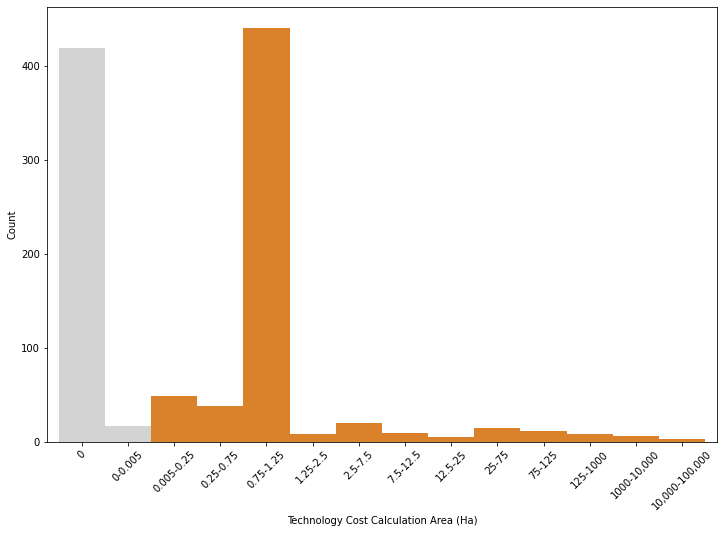

In [14]:
print(df.loc[(df['tech_perarea_size_hectares'] > 0) & (df['tech_perarea_size_hectares'] <= 0.005)]['url'].count())
# print(df['tech_perarea_size_hectares'].value_counts())
bins = [0,0.00001,0.005,0.25,0.75,1.25,2.5,7.5,12.5,25,75,125, 1000, 10000, 1000000]
tech_area_plot = df.loc[df['4_5_tech_input_est_total_costs'].notna() | df['4_7_tech_input_maint_total_costs'].notna()] # Used to remove no costs data
y, x = np.histogram(tech_area_plot['tech_perarea_size_hectares'], bins=bins)
x = x[1:]
hist = pd.Series(y, x)
colors = ['#d3d3d3', '#d3d3d3', '#da812c', '#da812c', '#da812c', '#da812c', '#da812c', '#da812c', '#da812c', '#da812c', '#da812c', '#da812c', '#da812c', '#da812c']
ax = hist.plot(kind='bar', width=1, align='center', color=colors)
ax.set_title('')
ax.set_xlabel('Technology Cost Calculation Area (Ha)')
ax.set_ylabel('Count')
ax.set_xticklabels(['0','0-0.005','0.005-0.25', '0.25-0.75', '0.75-1.25', '1.25-2.5', '2.5-7.5', '7.5-12.5', '12.5-25','25-75', '75-125', '125-1000', '1000-10,000', '10,000-100,000'], rotation='horizontal')
plt.xticks(rotation=45)
# plt.savefig('Report/Figures/AreaDistribution.png', bbox_inches = "tight")


### Country, Continent and UN Region Assignment
Using the UN Statistics standard country definitions
https://unstats.un.org/unsd/methodology/m49/overview/


In [15]:
df.at['4233', '2_5_tech_country'] = "Thailand"
df_country = pd.read_excel('./Country_Codes_Regions.xlsx', header=0, index_col=[8])
df_country.rename(index={
    'Bolivia (Plurinational State of)': 'Bolivia, Plurinational State of',
    'Cabo Verde': 'Cape Verde',
    'Iran (Islamic Republic of)': 'Iran, Islamic Republic of',
    'Republic of Moldova': 'Moldova, Republic of',
    'United Republic of Tanzania': 'Tanzania, United Republic of',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
},inplace=True)

# df_country
df.dropna(axis=0, subset=['url'], inplace=True)

In [16]:
region = df_country.loc[df['2_5_tech_country']]['Region Name']
region = region.reset_index().drop('Country or Area', axis=1).set_index(df.index).rename({'Region Name': 'Continent'}, axis=1)
sub_region = df_country.loc[df['2_5_tech_country']]['Sub-region Name']
sub_region = sub_region.reset_index().drop('Country or Area', axis=1).set_index(df.index)
intermediate_region = df_country.loc[df['2_5_tech_country']]['Intermediate Region Name']
intermediate_region = intermediate_region.reset_index().drop('Country or Area', axis=1).set_index(df.index)

df = pd.concat([df, region, sub_region, intermediate_region], axis=1)

### Land Use
Combine 2015 format with 2018


In [17]:
df['3_2_tech_landuse_type'] = df['3_2_tech_landuse_type'].combine_first(df['3_2_tech_landuse_type_2018'])

df['3_3_tech_initial_landuse_changed'].replace({
    'Yes (Please fill out the questions below with regard to the land use before implementation of the Technology)': 'Yes',
    'No (Continue with question 3.4)': 'No'
}, inplace=True)

# df.loc[:, ['3_2_tech_landuse_type', '3_3_tech_initial_landuse_changed', '3_2_tech_lu_mixed_select', '3_2_tech_lu_cropland_sub', '3_2_tech_lu_grazingland_extensive', '3_2_tech_lu_grazingland_intensive', 
#            '3_2_tech_lu_forest_type', '3_2_tech_lu_forest_natural', '3_2_tech_lu_forest_plantation', '3_2_tech_lu_settlements_sub', '3_2_tech_lu_waterways_sub',]]



## Type of SLM Measure

Within the dataset users are able to classify the technology according to 5 types: agronomic, vegative, structural, management and other. Users are able to select as many categories as are relevant, therefore we have split out the main selection groups into the following categories with any other combinations assigned to other.

- agronomic, vegative, structural and management
- vegative and structural
- vegative and management
- agronomic and vegative
- agronomic and management
- agronomic and structural
- agronomic, vegative and management
- agronomic, vegative and structural
- vegative, structural and management
- agronomic
- vegetative
- structural
- management
- other


In [18]:
# Split out Type of SLM Measure
df['3_6_tech_measures'] = df['3_6_tech_measures'].astype(str)
df['3_6_tech_measures_agronomic'] = ['agronomic' in measures for measures in df['3_6_tech_measures']]
df['3_6_tech_measures_vegetative'] = ['vegetative' in measures for measures in df['3_6_tech_measures']]
df['3_6_tech_measures_structural'] = ['structural' in measures for measures in df['3_6_tech_measures']]
df['3_6_tech_measures_management'] = ['management' in measures for measures in df['3_6_tech_measures']]
df['3_6_tech_measures_other'] = ['other' in measures for measures in df['3_6_tech_measures']]

# classify into 8 categories: 5 main plus, all, vegetative with structural and vegetative with management measures
classified_measures_conditions = [
    df['3_6_tech_measures_vegetative'] & df['3_6_tech_measures_structural'] & ~df['3_6_tech_measures_agronomic'] & ~df['3_6_tech_measures_management'] & ~df['3_6_tech_measures_other'],
    df['3_6_tech_measures_vegetative'] & df['3_6_tech_measures_management'] & ~df['3_6_tech_measures_agronomic'] & ~df['3_6_tech_measures_structural'] & ~df['3_6_tech_measures_other'],
    df['3_6_tech_measures_vegetative'] & df['3_6_tech_measures_management'] & df['3_6_tech_measures_agronomic'] & df['3_6_tech_measures_structural'] & ~df['3_6_tech_measures_other'],
    df['3_6_tech_measures_agronomic'] & df['3_6_tech_measures_vegetative'] & ~df['3_6_tech_measures_management'] & ~df['3_6_tech_measures_structural'] & ~df['3_6_tech_measures_other'],
    df['3_6_tech_measures_agronomic'] & df['3_6_tech_measures_management'] & ~df['3_6_tech_measures_vegetative'] & ~df['3_6_tech_measures_structural'] & ~df['3_6_tech_measures_other'],
    df['3_6_tech_measures_agronomic'] & df['3_6_tech_measures_structural'] & ~df['3_6_tech_measures_vegetative'] & ~df['3_6_tech_measures_management'] & ~df['3_6_tech_measures_other'],
    df['3_6_tech_measures_agronomic'] & df['3_6_tech_measures_management'] & df['3_6_tech_measures_vegetative'] & ~df['3_6_tech_measures_structural'] & ~df['3_6_tech_measures_other'],
    df['3_6_tech_measures_agronomic'] & ~df['3_6_tech_measures_management'] & df['3_6_tech_measures_vegetative'] & df['3_6_tech_measures_structural'] & ~df['3_6_tech_measures_other'],
    ~df['3_6_tech_measures_agronomic'] & df['3_6_tech_measures_management'] & df['3_6_tech_measures_vegetative'] & df['3_6_tech_measures_structural'] & ~df['3_6_tech_measures_other'],
    df['3_6_tech_measures_agronomic'] & ~df['3_6_tech_measures_vegetative'] & ~df['3_6_tech_measures_structural'] & ~df['3_6_tech_measures_management'] & ~df['3_6_tech_measures_other'],
    df['3_6_tech_measures_vegetative'] & ~df['3_6_tech_measures_agronomic'] & ~df['3_6_tech_measures_structural'] & ~df['3_6_tech_measures_management'] & ~df['3_6_tech_measures_other'],
    df['3_6_tech_measures_structural'] & ~df['3_6_tech_measures_vegetative'] & ~df['3_6_tech_measures_agronomic'] & ~df['3_6_tech_measures_management'] & ~df['3_6_tech_measures_other'],
    df['3_6_tech_measures_management'] & ~df['3_6_tech_measures_vegetative'] & ~df['3_6_tech_measures_structural'] & ~df['3_6_tech_measures_agronomic'] & ~df['3_6_tech_measures_other'],
    
]

classified_measures_values = [
    'agronomic, vegative, structural and management',
    'vegative and structural',
    'vegative and management',
    'agronomic and vegative',
    'agronomic and management',
    'agronomic and structural',
    'agronomic, vegative and management',
    'agronomic, vegative and structural',
    'vegative, structural and management',
    'agronomic',
    'vegetative',
    'structural',
    'management',
]

classified_measures = np.select(classified_measures_conditions, classified_measures_values, default='other')
classified_measures = pd.Series(classified_measures, df.index, name='classified_measures')

df = pd.concat([df, classified_measures], axis=1)


## Mapping the SLM Groups to a simplified list

In [19]:
slm_group_mapping = pd.read_excel('./SLM_Group_Mapping.xlsx', header=0, )
slm_group_mapping = dict(slm_group_mapping.values)
slm_group_mapping

df['slm_group_remapped'] = df['3_4_tech_slm_group'].replace(slm_group_mapping)

# Convert the pipe list into a python list
df['3_4_tech_slm_group'] = df['3_4_tech_slm_group'].astype(str)
df['3_4_tech_slm_group_list'] = df['3_4_tech_slm_group'].str.split('|')

## Category Cleaning
Improving readability of some dimensions for user ease on dashboard


In [20]:
land_use_summary = df['3_2_tech_landuse_type'].copy()
land_use_summary.replace(['Cropland|Waterways, waterbodies, wetlands',
                          'Cropland|Other'
                         ], 'Cropland', inplace=True)
land_use_summary.replace([
    'Mixed (crops/ grazing/ trees), incl. agroforestry',
    'Cropland|Forest/ woodlands|Waterways, waterbodies, wetlands',
    'Cropland|Mixed (crops/ grazing/ trees), incl. agroforestry',
    'Forest/ woodlands|Mixed (crops/ grazing/ trees), incl. agroforestry',
    'Grazing land|Forest/ woodlands|Unproductive land'
], 'Cropland|Grazing land|Forest/ woodlands', inplace=True)
land_use_summary.replace([
    'Grazing land|Other'
], 'Grazing land', inplace=True)
land_use_summary.replace([
    'Forest/ woodlands|Other'
], 'Forest/ woodlands', inplace=True)
land_use_summary.replace([
    'Cropland|Unproductive land',
    'Grazing land|Unproductive land',
    'Unproductive land',
    'Forest/ woodlands|Unproductive land'
], 'Restoring unproductive lands', inplace=True)
land_use_summary.replace([
    'Settlements, infrastructure',
    'Cropland|Settlements, infrastructure'
], 'Settlements', inplace=True)
land_use_summary.replace([
    'Grazing land|Waterways, waterbodies, wetlands',
    'Cropland|Grazing land|Settlements, infrastructure',
    'Cropland|Grazing land|Other',
    'Grazing land|Settlements, infrastructure',
    'Forest/ woodlands|Settlements, infrastructure',
    'Mixed (crops/ grazing/ trees), incl. agroforestry|Waterways, waterbodies, wetlands',
    'Other',
    'Grazing land|Mixed (crops/ grazing/ trees), incl. agroforestry',
    'Forest/ woodlands|Settlements, infrastructure|Waterways, waterbodies, wetlands',
    'Grazing land|Mines, extractive industries',
    'Cropland|Forest/ woodlands|Settlements, infrastructure',
    'Cropland|Forest/ woodlands|Unproductive land',
    'Cropland|Grazing land|Waterways, waterbodies, wetlands',
    'nan'
], 'Other mixed land uses', inplace=True)

land_use_summary = pd.Series(land_use_summary, df.index, name='land_use_summary')
land_use_summary = land_use_summary.str.replace('|', ', ', regex=True)
land_use_summary.fillna('Not Documented', inplace=True)
# land_use_summary
df = pd.concat([df, land_use_summary], axis=1)

In [21]:
# Altitude harmonization
df['5_2_tech_altitudinalzone'].replace({
    '1,001-1,500 m a.s.l.|1,501-2,000 m a.s.l.': '1,001-2,000 m a.s.l.',
    '2,001-2,500 m a.s.l.|2,501-3,000 m a.s.l.': '2,001-3,000 m a.s.l.',
    '1,501-2,000 m a.s.l.|2,001-2,500 m a.s.l.': '1,501-2,500 m a.s.l.',
    '1,501-2,000 m a.s.l.|2,501-3,000 m a.s.l.': '1,501-3,000 m a.s.l.',
    '101-500 m a.s.l.|501-1,000 m a.s.l.': '101-1,000 m a.s.l.',
    '0-100 m a.s.l.|101-500 m a.s.l.': '0-500 m a.s.l.',
    '3,001-4,000 m a.s.l.|> 4,000 m a.s.l.': '3,001- >4,000 m a.s.l.',
    '501-1,000 m a.s.l.|1,001-1,500 m a.s.l.': '501-1,500 m a.s.l.',
    '101-500 m a.s.l.|1,001-1,500 m a.s.l.': '101-1,500 m a.s.l.',
    '501-1,000 m a.s.l.|1,501-2,000 m a.s.l.': '501-2,000 m a.s.l.',
    '1,001-1,500 m a.s.l.|3,001-4,000 m a.s.l.': '1,001-4,000 m a.s.l.',
    '2,501-3,000 m a.s.l.|3,001-4,000 m a.s.l.': '2,501-4,000 m a.s.l.',
    '0-100 m a.s.l.|1,501-2,000 m a.s.l.': '0-2,000 m a.s.l.',
    '0-100 m a.s.l.|501-1,000 m a.s.l.': '0-1,000 m a.s.l.',
    '101-500 m a.s.l.|1,501-2,000 m a.s.l.': '101-2,000 m a.s.l.',
    '501-1,000 m a.s.l.|2,001-2,500 m a.s.l.': '501-2,500 m a.s.l.',
    '1,001-1,500 m a.s.l.|2,001-2,500 m a.s.l.': '1,001-2,500 m a.s.l.'
}, inplace=True)
df['5_2_tech_altitudinalzone'].fillna('Not Documented', inplace=True)


# df['5_2_tech_altitudinalzone'].value_counts()

In [22]:
# Land Size
df['5_7_tech_tech_land_size'].replace({
    '< 0.5 ha|2-5 ha': '0-5 ha',
    '1-2 ha|> 10,000 ha': '1- >10,000 ha',
    '< 0.5 ha|100-500 ha': '0-500 ha',
    '1-2 ha|2-5 ha': '1-5 ha',
    '< 0.5 ha|15-50 ha': '0-50 ha',
    '< 0.5 ha|0.5-1 ha': '0-1 ha',
    '5-15 ha|15-50 ha': '5-50 ha',
    '0.5-1 ha|1-2 ha': '0.5-2 ha',
    '1,000-10,000 ha|> 10,000 ha': '1,000- >10,000 ha',
    '50-100 ha|100-500 ha': '50-500 ha',
    '0.5-1 ha|2-5 ha': '0.5-5 ha',
    '< 0.5 ha|1-2 ha': '0-2 ha',
    '500-1,000 ha|1,000-10,000 ha': '500-10,000 ha',
    '2-5 ha|5-15 ha': '2-15 ha',
    '< 0.5 ha|5-15 ha': '0-15 ha',
    '15-50 ha|100-500 ha': '15-500 ha',
    '2-5 ha|15-50 ha': '2-50 ha',
    '0.5-1 ha|5-15 ha': '0.5-15 ha',
    '15-50 ha|100-500 ha': '15-500 ha',
    '2-5 ha|15-50 ha': '2-50 ha',
    '0.5-1 ha|5-15 ha': '0.5-15 ha',
    '15-50 ha|50-100 ha': '15-100 ha',
    '1-2 ha|5-15 ha': '1-15 ha',
    '5-15 ha|100-500 ha': '5-500 ha',
    '100-500 ha|500-1,000 ha': '100-1,000 ha',
    '5-15 ha|50-100 ha': '5-100 ha',
    '15-50 ha|1,000-10,000 ha': '15-10,000 ha',
    '1-2 ha|15-50 ha': '1-50 ha',
    '2-5 ha|500-1,000 ha': '2-1,000 ha',    
}, inplace=True)
df['5_7_tech_tech_land_size'].fillna('Not Documented', inplace=True)

# df['5_7_tech_tech_land_size'].value_counts()


In [23]:
# Annual Rainfall
df['5_1_tech_rainfall'].replace({
    '251-500 mm|501-750 mm': '251-750 mm',
    '501-750 mm|751-1,000 mm': '501-1,000 mm',
    '2,001-3,000 mm|3,001-4,000 mm': '2,001-4,000 mm',
    '1,501-2,000 mm|2,001-3,000 mm': '1,501-3,000 mm',
    '751-1,000 mm|1,001-1,500 mm': '751-1,500 mm',
    '1,001-1,500 mm|1,501-2,000 mm': '1,001-2,000 mm',
    '< 250 mm|251-500 mm': '< 250-500 mm',
    '501-750 mm|1,001-1,500 mm': '501-1,500 mm',
    '< 250 mm|501-750 mm': '< 250-750 mm',
    '251-500 mm|751-1,000 mm': '251-1,000 mm',
    '1,001-1,500 mm|2,001-3,000 mm': '1,001-3,000 mm',
    '251-500 mm|2,001-3,000 mm': '251-3,000 mm',
    '< 250 mm|751-1,000 mm': '< 250-1,000 mm'
}, inplace=True)
df['5_1_tech_rainfall'].fillna('Not Documented', inplace=True)

# df['5_1_tech_rainfall'].value_counts()

In [24]:
df['3_7_tech_degradation'] = df['3_7_tech_degradation'].str.replace('|', ', ', regex=True).fillna('Not Documented')
df['5_2_tech_landforms'] = df['5_2_tech_landforms'].str.replace('|', ', ', regex=True).fillna('Not Documented')
df['5_1_tech_agroclimatic_zone'] = df['5_1_tech_agroclimatic_zone'].str.replace('|', ', ', regex=True).fillna('Not Documented')
df['3_1_tech_main_purpose'] = df['3_1_tech_main_purpose'].str.replace('|', ', ', regex=True).fillna('Not Documented')
df['5_2_tech_slopes'] = df['5_2_tech_slopes'].str.replace('|', ', ', regex=True).fillna('Not Documented')

## Technology resistance to events

To Do
Summarise resistance values using mode:
| Summary | Columns |
| --- | --- |
| Temp | '6_3_tech_annualtemperature_exposure_sensitivity' |
| Rain | '6_3_tech_annualrainfall_exposure_sensitivity' |
| Storms |'6_3_tech_climarelated_tropicalstrom_exposure_sensitivity', '6_3_tech_climarelated_extratropicalcyclone_exposure_sensitivity', '6_3_tech_climarelated_localrainstorm_exposure_sensitivity', '6_3_tech_climarelated_localthunderstrom_exposure_sensitivity', '6_3_tech_climarelated_localhailstorm_exposure_sensitivity', '6_3_tech_climarelated_localsnowstorm_exposure_sensitivity', '6_3_tech_climarelated_localsandduststorm_exposure_sensitivity', '6_3_tech_climarelated_localwindstorm_exposure_sensitivity', '6_3_tech_climarelated_tornado_exposure_sensitivity' |
| Fire | '6_3_tech_climarelated_forestfire_exposure_sensitivity', '6_3_tech_climarelated_landfire_exposure_sensitivity' |
| Flood | '6_3_tech_climarelated_generalriverflood_exposure_sensitivity', '6_3_tech_climarelated_flashflood_exposure_sensitivity', '6_3_tech_climarelated_stromsurgecostalflood_exposure_sensitivity' |
| Drought | '6_3_tech_climarelated_drought_exposure_sensitivity' |
| Landslides | '6_3_tech_climarelated_landslide_exposure_sensitivity' | 
| Pests | '6_3_tech_climarelated_insectinfestation_exposure_sensitivity' |
    


In [25]:
# Map over the columns converting to numbers, calculate mean, round result and convert back to text
likert_to_number = {
    'not well at all': 1,
    'not well': 2,
    'moderately': 3,
    'well': 4,
    'very well': 5,
    'not known': 0
}
number_to_likert = {
    1: 'not well at all',
    2: 'not well',
    3: 'moderately',
    4: 'well',
    5: 'very well',
    0: 'not known'
}

columns = ['6_3_tech_climarelated_tropicalstrom_exposure_sensitivity', '6_3_tech_climarelated_extratropicalcyclone_exposure_sensitivity', 
           '6_3_tech_climarelated_localrainstorm_exposure_sensitivity', '6_3_tech_climarelated_localthunderstrom_exposure_sensitivity', 
           '6_3_tech_climarelated_localhailstorm_exposure_sensitivity', '6_3_tech_climarelated_localsnowstorm_exposure_sensitivity', 
           '6_3_tech_climarelated_localsandduststorm_exposure_sensitivity', '6_3_tech_climarelated_localwindstorm_exposure_sensitivity', 
           '6_3_tech_climarelated_tornado_exposure_sensitivity', '6_3_tech_climarelated_forestfire_exposure_sensitivity', 
           '6_3_tech_climarelated_landfire_exposure_sensitivity', '6_3_tech_climarelated_generalriverflood_exposure_sensitivity', 
           '6_3_tech_climarelated_flashflood_exposure_sensitivity', '6_3_tech_climarelated_stromsurgecostalflood_exposure_sensitivity']

df.loc[:, columns] = df.loc[:, columns].replace(likert_to_number) 

storm_sensitivity = df.loc[:, ['6_3_tech_climarelated_tropicalstrom_exposure_sensitivity', '6_3_tech_climarelated_extratropicalcyclone_exposure_sensitivity', '6_3_tech_climarelated_localrainstorm_exposure_sensitivity', '6_3_tech_climarelated_localthunderstrom_exposure_sensitivity', '6_3_tech_climarelated_localhailstorm_exposure_sensitivity', '6_3_tech_climarelated_localsnowstorm_exposure_sensitivity', '6_3_tech_climarelated_localsandduststorm_exposure_sensitivity', '6_3_tech_climarelated_localwindstorm_exposure_sensitivity', '6_3_tech_climarelated_tornado_exposure_sensitivity']].median(axis=1).round(decimals=0)
fire_sensitivity = df.loc[:, ['6_3_tech_climarelated_forestfire_exposure_sensitivity', '6_3_tech_climarelated_landfire_exposure_sensitivity']].median(axis=1).round(decimals=0)
flood_sensitivity = df.loc[:, ['6_3_tech_climarelated_generalriverflood_exposure_sensitivity', '6_3_tech_climarelated_flashflood_exposure_sensitivity', '6_3_tech_climarelated_stromsurgecostalflood_exposure_sensitivity']].median(axis=1).round(decimals=0)

df.loc[:, columns] = df.loc[:, columns].replace(number_to_likert)
storm_sensitivity = storm_sensitivity.replace(number_to_likert).rename('storm_sensitivity')
fire_sensitivity = fire_sensitivity.replace(number_to_likert).rename('fire_sensitivity')
flood_sensitivity = flood_sensitivity.replace(number_to_likert).rename('flood_sensitivity')

temperature_sensitivity = df['6_3_tech_annualtemperature_exposure_sensitivity'].rename('temperature_sensitivity')
rain_sensitivity = df['6_3_tech_annualrainfall_exposure_sensitivity'].rename('rain_sensitivity')
drought_sensitivity = df['6_3_tech_climarelated_drought_exposure_sensitivity'].rename('drought_sensitivity')
landslide_sensitivity = df['6_3_tech_climarelated_landslide_exposure_sensitivity'].rename('landslide_sensitivity')
pest_sensitivity = df['6_3_tech_climarelated_insectinfestation_exposure_sensitivity'].rename('pest_sensitivity')

df = pd.concat([df, storm_sensitivity, fire_sensitivity, flood_sensitivity, temperature_sensitivity, rain_sensitivity, drought_sensitivity, landslide_sensitivity, pest_sensitivity], axis=1)

## Benefit Aggregation

In [26]:
# Benefit Aggregation
benefits_to_likert = {
    -3: 'Very negative (-50-100%)',
    -2: 'Negative (-20-50%)',
    -1: 'Slightly negative (-5-20%)',
    0:  'Negligible impact (-5-+5%)',
    1:  'Slightly positive (+5-20%)',
    2:  'Positive (+20-50%)',
    3:  'Very positive (+50-100%)'
}

# Onsite Benefits
# Socio-economic impacts
socio_economic_production_benefits_num = df.loc[:, ['6_1_sei_production_cropproduction', '6_1_sei_production_cropquality', 
                                 '6_1_sei_production_fodderproduction', '6_1_sei_production_fodderquality', 
                                 '6_1_sei_production_animalproduction', '6_1_sei_production_woodproduction', 
                                 '6_1_sei_production_forestquality', '6_1_sei_production_nonwoodforestproduction',
                                 '6_1_sei_production_productionfailure', '6_1_sei_production_productdiversity',
                                 '6_1_sei_production_productionarea', '6_1_sei_production_landmanagement',
                                 '6_1_sei_production_energygeneration']].astype(float).median(axis=1).round(decimals=0)\
                                    .rename('socio_economic_production_benefits_num')
socio_economic_production_benefits = socio_economic_production_benefits_num.replace(benefits_to_likert).rename('socio_economic_production_benefits')

socio_economic_water_benefits_num = df.loc[:, ['6_1_sei_water_drinkingwateravailability', '6_1_sei_water_drinkingwaterquality',
                            '6_1_sei_water_livestockwateravailability', '6_1_sei_water_livestockwaterquality',
                            '6_1_sei_water_irrigationwateravailability', '6_1_sei_water_irrigationwaterquality',
                            '6_1_sei_water_demandirrigationwater']].astype(float).median(axis=1).round(decimals=0)\
                                    .rename('socio_economic_water_benefits_num')
socio_economic_water_benefits = socio_economic_water_benefits_num.replace(benefits_to_likert).rename('socio_economic_water_benefits')

socio_economic_income_benefits_num = df.loc[:, ['6_1_sei_income_expenses', '6_1_sei_income_farmincome', 
                             '6_1_sei_income_diversityincome', '6_1_sei_income_economicdisparities',
                             '6_1_sei_income_workload']].astype(float).median(axis=1).round(decimals=0)\
                                    .rename('socio_economic_income_benefits_num')
socio_economic_income_benefits = socio_economic_income_benefits_num.replace(benefits_to_likert).rename('socio_economic_income_benefits')

# Socio-cultural impacts
socio_cultural_benefits_num = df.loc[:, ['6_1_sci_foodsecurity', '6_1_sci_healthsituation',
                                     '6_1_sci_landusewaterrights', '6_1_sci_culturalopportunities',
                                     '6_1_sci_recreationalopportunities', '6_1_sci_communityinstitutions',
                                     '6_1_sci_nationalinstitutions', '6_1_sci_slmknowledge',
                                     '6_1_sci_conflictmitigation', '6_1_sci_situationdisadvantaged']].astype(float).median(axis=1).round(decimals=0)\
                                    .rename('socio_cultural_benefits_num')
socio_cultural_benefits = socio_cultural_benefits_num.replace(benefits_to_likert).rename('socio_cultural_benefits')

# Ecological impacts
ecological_water_benefits_num = df.loc[:, ['6_1_ei_waterquantity', '6_1_ei_waterquality',
                                       '6_1_ei_harvestingwater', '6_1_ei_surfacerunoff', 
                                       '6_1_ei_waterdrainage', '6_1_ei_groundwater',
                                       '6_1_ei_evaporation']].astype(float).median(axis=1).round(decimals=0)\
                                    .rename('ecological_water_benefits_num')
ecological_water_benefits = ecological_water_benefits_num.replace(benefits_to_likert).rename('ecological_water_benefits')

ecological_soil_benefits_num = df.loc[:, ['6_1_ei_soilmoisture', '6_1_ei_soilcover', 
                                      '6_1_ei_soilloss', '6_1_ei_soilaccumulation', 
                                      '6_1_ei_soilcrusting', '6_1_ei_soilcompaction',
                                      '6_1_ei_nutrientcycling', '6_1_ei_soilsalinity',
                                      '6_1_ei_soilorganicmatter', '6_1_ei_soilacidity']].astype(float).median(axis=1).round(decimals=0)\
                                    .rename('ecological_soil_benefits_num')
ecological_soil_benefits = ecological_soil_benefits_num.replace(benefits_to_likert).rename('ecological_soil_benefits')

ecological_biodiversity_benefits_num = df.loc[:, ['6_1_ei_vegetationcover', '6_1_ei_biomass',
                                          '6_1_ei_plantdiversity', '6_1_ei_invasivespecies',
                                          '6_1_ei_animaldiversity', '6_1_ei_beneficialspecies', 
                                          '6_1_ei_habitatdiversity', '6_1_ei_pestcontrol']].astype(float).median(axis=1).round(decimals=0)\
                                    .rename('ecological_biodiversity_benefits_num')
ecological_biodiversity_benefits = ecological_biodiversity_benefits_num.replace(benefits_to_likert).rename('ecological_biodiversity_benefits')

ecological_climate_disaster_risk_benefits_num = df.loc[:, ['6_1_ei_floodimpacts', '6_1_ei_landslides',
                                                       '6_1_ei_droughtimpacts', '6_1_ei_cyclones',
                                                       '6_1_ei_emissioncarbon', '6_1_ei_firerisk',
                                                       '6_1_ei_windvelocity', '6_1_ei_microclimate_specify']].astype(float).median(axis=1).round(decimals=0)\
                                    .rename('ecological_climate_disaster_risk_benefits_num')
ecological_climate_disaster_risk_benefits = ecological_climate_disaster_risk_benefits_num.replace(benefits_to_likert).rename('ecological_climate_disaster_risk_benefits')

# Offsite Benefits
offsite_benefits_num = df.loc[:, ['6_2_tech_impacts_wateravailability', '6_2_tech_impacts_reliableflows',
                             '6_2_tech_impacts_downstreamflooding', '6_2_tech_impacts_downstreamsiltation',
                             '6_2_tech_impacts_groundwaterpollution', '6_2_tech_impacts_bufferingcapacity',
                             '6_2_tech_impacts_windtransportedsediments', '6_2_tech_impacts_damageneighbourfield',
                             '6_2_tech_impacts_damageinfrastructure', '6_2_tech_impacts_impactgreenhousegases']].astype(float).median(axis=1).round(decimals=0)\
                                    .rename('offsite_benefits_num')
offsite_benefits = offsite_benefits_num.replace(benefits_to_likert).rename('offsite_benefits')


In [27]:
df = pd.concat([df, socio_economic_production_benefits_num, socio_economic_water_benefits_num, socio_economic_income_benefits_num, 
                socio_cultural_benefits_num, ecological_water_benefits_num, ecological_soil_benefits_num, ecological_biodiversity_benefits_num, 
                ecological_climate_disaster_risk_benefits_num, offsite_benefits_num], axis=1)

df = pd.concat([df, socio_economic_production_benefits, socio_economic_water_benefits, socio_economic_income_benefits, socio_cultural_benefits, ecological_water_benefits, 
               ecological_soil_benefits, ecological_biodiversity_benefits, ecological_climate_disaster_risk_benefits, offsite_benefits], axis=1)


## Convert perceived benefits to numbers


In [28]:
likert_to_numbers = {
    'very negative': -3,
    'negative': -2,
    'slightly negative': -1,
    'neutral/ balanced': 0,
    'slightly positive': 1,
    'positive': 2,
    'very positive': 3,
}

tech_costbenefit_est_short_num = df['6_4_tech_costbenefit_est_short'].replace(likert_to_numbers).rename('tech_costbenefit_est_short_num')
tech_costbenefit_est_long_num = df['6_4_tech_costbenefit_establishment_est_long'].replace(likert_to_numbers).rename('tech_costbenefit_est_long_num')
tech_costbenefit_maint_short_num = df['6_4_tech_costbenefit_establishment_est_short'].replace(likert_to_numbers).rename('tech_costbenefit_maint_short_num')
tech_costbenefit_maint_long_num = df['6_4_tech_costbenefit_maintenance_est_long'].replace(likert_to_numbers).rename('tech_costbenefit_maint_long_num')

df = pd.concat([df, tech_costbenefit_est_short_num, tech_costbenefit_est_long_num, tech_costbenefit_maint_short_num, tech_costbenefit_maint_long_num], axis=1)


## Backup full dataset


In [29]:
full_dataset = df.copy()

## Handling infinite costs per hectare

As the technology area trends to 0 the costs per hectare trend to infinity, therefore it is necessary to remove technologies with an area less than 0.005 hectares (538 sq feet or 50 sq meters). This leaves us with 591 technologies to include in the analysis.

1236
1053


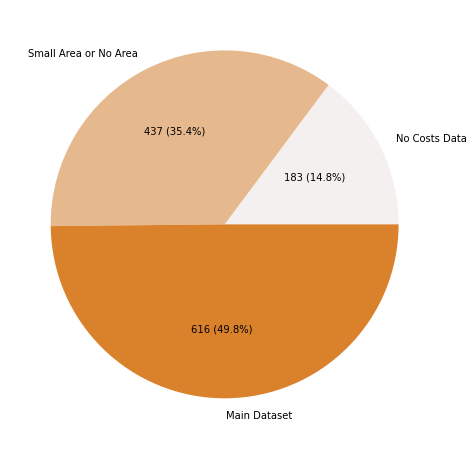

In [30]:
no_costs = full_dataset.loc[full_dataset['4_5_tech_input_est_total_costs'].isna() & full_dataset['4_7_tech_input_maint_total_costs'].isna()]
costs_data = full_dataset.loc[full_dataset['4_5_tech_input_est_total_costs'].notna() | full_dataset['4_7_tech_input_maint_total_costs'].notna()]
small_area = costs_data.loc[(costs_data['tech_perarea_size_hectares'] <= 0.005) | (costs_data['tech_perarea_size_hectares'].isna())]
main_dataset = costs_data.loc[(costs_data['tech_perarea_size_hectares'] > 0.005)]

no_costs.index.size
small_area.index.size
main_dataset.index.size

pie_data = [no_costs.index.size, small_area.index.size, main_dataset.index.size]
pie_labels = ['No Costs Data', 'Small Area or No Area', 'Main Dataset']

color= sns.light_palette("#da812c", 3)
plt.pie(pie_data, labels=pie_labels,  autopct=lambda p : '{:,.0f} ({:.1f}%)  '.format(p * sum(pie_data)/100, p), colors=color)
# plt.savefig('Report/Figures/datasetDistributionPie.png', bbox_inches = "tight")

df = main_dataset
df_small_area = small_area

print(full_dataset.index.size)
print(costs_data.index.size)


In [31]:
# Full Dataset
# Technologies, Approaches
# Costs Data, No Costs Data
# Area, No Area or Less than 0.005 ha

color = list(sns.light_palette("#da812c", 11).as_hex())

# fig = go.Figure(data=[go.Sankey(
#     arrangement = "perpendicular",
#     node = dict(
#       pad = 15,
#       thickness = 20,
#       line = dict(color = "black", width = 0.5),
#       label = ["Full Dataset (2185)", "Technologies (1236)", "Approaches (499)", "UNCCD PRAIS Practices (433)", "Costs Data (1053)", "No Costs Data (183)", "Area Data (616)", "No Area Data or Small Area (437)", "Discarded (1569)", "Main Dataset (616)"],# "B1", "B2", "C1", "C2"],
#       color = color
#     ),
# #     link = dict(
# #       source = [0, 0, 1, 1, 2, 4, 3, 3, 5, 6, ],
# #       target = [1, 2, 3, 4, 7, 7, 5, 6, 8, 7, ],
# #       value = [10, 8, 5, 5, 8, 5, 4, 1, 4, 1,],
# #   )
#     link = dict(
#       source = [0, 0, 0, 1, 1, 4, 4, 2, 3, 5, 7, 6],
#       target = [1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 8, 9],
#       value = [1236, 499, 443, (1236-183), 183, 616, 437, 499, 443, 183, 437, 616],
#   )

# )])

fig = go.Figure(data=[go.Sankey(
    arrangement = "perpendicular",
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Full Dataset (2185)", "Technologies (1236)", "Approaches (499)", "UNCCD PRAIS Practices (433)", "Costs Data (1053)", "No Costs Data (183)", "Area Data (616)", "No Area Data or Small Area (437)", "Discarded (1569)", "Outliers (109)", "Final Dataset (507)"],# "B1", "B2", "C1", "C2"],
      color = color
    ),
    link = dict(
      source = [0, 0, 0, 1, 1, 4, 4, 2, 3, 5, 7, 6, 6, 9],
      target = [1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 8, 9, 10, 8],
      value = [1236, 499, 443, (1236-183), 183, 616, 437, 499, 443, 183, 437, 109, 507, 109],
  )

)])

fig.update_layout(title_text="", font_size=10)



## Conversion to USD/ha and labour/ha

The costs and labour data is then converted to per hectare values for the analysis

In [32]:
# Converted costs per ha
tech_input_est_total_costs_2020_usd_per_ha = df['4_5_tech_input_est_total_costs_2020_usd']/df['tech_perarea_size_hectares']
tech_input_est_total_costs_2020_usd_per_ha = pd.Series(tech_input_est_total_costs_2020_usd_per_ha, df.index, name='4_5_tech_input_est_total_costs_2020_usd_per_ha')

tech_input_maint_total_costs_2020_usd_per_ha = df['4_7_tech_input_maint_total_costs_2020_usd']/df['tech_perarea_size_hectares']
tech_input_maint_total_costs_2020_usd_per_ha = pd.Series(tech_input_maint_total_costs_2020_usd_per_ha, df.index, name='4_7_tech_input_maint_total_costs_2020_usd_per_ha')

df = pd.concat([df, tech_input_est_total_costs_2020_usd_per_ha, tech_input_maint_total_costs_2020_usd_per_ha], axis=1)



In [33]:
# Total present values per ha
def convert_total_present_value_to_per_ha(total_present_values, annuity_costs):
    total_present_values_per_ha = df[total_present_values]/df['tech_perarea_size_hectares']
    total_present_values_per_ha = pd.Series(total_present_values_per_ha, df.index, name=total_present_values+'_per_ha')
    annuity_costs_per_ha = df[annuity_costs]/df['tech_perarea_size_hectares']
    annuity_costs_per_ha = pd.Series(annuity_costs_per_ha, df.index, name=annuity_costs+'_per_ha')
    return total_present_values_per_ha, annuity_costs_per_ha

total_present_values_0_per_ha, annuity_costs_0_per_ha = convert_total_present_value_to_per_ha('total_present_values_0', 'annuity_costs_0')
total_present_values_2_5_per_ha, annuity_costs_2_5_per_ha = convert_total_present_value_to_per_ha('total_present_values_2_5', 'annuity_costs_2_5')
total_present_values_5_per_ha, annuity_costs_5_per_ha = convert_total_present_value_to_per_ha('total_present_values_5', 'annuity_costs_5')

df = pd.concat([df, total_present_values_0_per_ha, annuity_costs_0_per_ha,
                total_present_values_2_5_per_ha, annuity_costs_2_5_per_ha,
                total_present_values_5_per_ha, annuity_costs_5_per_ha], axis=1)



In [34]:
establishment_costs_per_ha = establishment_costs.apply(lambda x: x/df['tech_perarea_size_hectares'])
establishment_costs_per_ha.columns = ['labour_est_per_ha', 'equipment_est_per_ha', 'plant_est_per_ha', 'fertilizer_est_per_ha', 'construction_est_per_ha', 'other_est_per_ha']
maintenance_costs_per_ha = maintenance_costs.apply(lambda x: x/df['tech_perarea_size_hectares'])
maintenance_costs_per_ha.columns = ['labour_maint_per_ha', 'equipment_maint_per_ha', 'plant_maint_per_ha', 'fertilizer_maint_per_ha', 'construction_maint_per_ha', 'other_maint_per_ha']

df = pd.concat([df, establishment_costs_per_ha, maintenance_costs_per_ha], axis=1)

In [35]:
labour_est_days_per_ha = labour_est_days/df['tech_perarea_size_hectares']
labour_est_days_per_ha = pd.Series(labour_est_days_per_ha, df.index, name='labour_est_days_per_ha')
labour_maint_days_per_ha = labour_maint_days/df['tech_perarea_size_hectares']
labour_maint_days_per_ha = pd.Series(labour_maint_days_per_ha, df.index, name='labour_maint_days_per_ha')

df = pd.concat([df, labour_est_days_per_ha, labour_maint_days_per_ha], axis=1)

## Outlier calculation
The outlier classifier looks at the 0% Total Present Value costs by SLM Group and removes values that exceed 1.5 times the inter quartile range from the upper and lower quartile.
Technologies priced per technology unit have also been excluded.

In [36]:
# Removing outliers by category
res = df.groupby(['slm_group_remapped'])['total_present_values_0_per_ha'].quantile([0.25, 0.75]).unstack(level=1)
iqr = res[0.75] - res[0.25]
res['lower_outliers'] = res[0.25] - iqr*1.5
res['higher_outliers'] = res[0.75] + iqr*1.5
# print(res)
lower_outlier = (df['slm_group_remapped'].map(res['lower_outliers']) > df['total_present_values_0_per_ha'])
upper_outlier = (df['total_present_values_0_per_ha'].values > df['slm_group_remapped'].map(res['higher_outliers']))

lower_outlier = pd.Series(lower_outlier, df.index, name='lower_outlier')
upper_outlier = pd.Series(upper_outlier, df.index, name='upper_outlier')

df = pd.concat([df, lower_outlier, upper_outlier], axis=1)

In [37]:
df = df.loc[df['4_3_tech_cost_calculation_base'] != 'per Technology unit']
df = df.loc[df['upper_outlier'] == False]
df = df.loc[df['lower_outlier'] == False]
df.dropna(axis=0, subset=['url']).index.size

507

## Final Dataset

Limiting the data to only include questionnaire responses with cost data and the following measures and dimensions.

### Dimensions
- Current Land Use
- Technology Aim
- Type of Measure
- SLM Group
- Continent
- UN Region
- Country
- Tech Area Land Size
- Topography
- Altitude
- Water Supply
- Gender

### Costs Measures
- Establishment Costs
- Maintenance Costs
- Establishment Costs per Hectare
- Maintenance Costs per Hectare
- Labour

### Benefits Measures
- Onsite Impacts
- Offsite Impacts
- Climate Change Sensitivity
- Adoption of the Technology
- Cost Benefit Analysis Responses


In [38]:
output_column_renaming = {
    '2_5_tech_country': 'Country',
    'Sub-region Name': 'Region',
    
    '3_1_tech_main_purpose': 'Main purpose', 
    '3_7_tech_degradation': 'Degradation addressed',
    'land_use_summary': 'Land use Simplified',
    '3_2_tech_landuse_type': 'Land use', 
    '3_2_tech_lu_mixed_select': 'Mixed land use type', 
    '3_2_tech_lu_cropland_sub': 'Cropland sub-category', 
    '3_2_tech_lu_grazingland_extensive': 'Grazing extensive sub-category', 
    '3_2_tech_lu_grazingland_intensive': 'Grazing intensive sub-category', 
    '3_2_tech_lu_forest_type': 'Forest type', 
    '3_2_tech_lu_forest_natural': 'Forest (Natural) sub-category', 
    '3_2_tech_lu_forest_plantation': 'Forest (Plantation) sub-category', 
    '3_2_tech_lu_settlements_sub': 'Settlement sub-category', 
    '3_2_tech_lu_waterways_sub': 'Waterways sub-category',
    '3_3_tech_initial_landuse_changed': 'Original landuse changed?', 
    '3_3_tech_landuse_type_2018_changed': 'Original landuse',
    '3_2_tech_watersupply': 'Watersupply', 
    '5_1_tech_rainfall': 'Annual rainfall', 
    '5_1_tech_agroclimatic_zone': 'Agroclimatic zone', 
    '5_2_tech_slopes': 'Slope angle', 
    '5_2_tech_landforms': 'Landforms',
    '5_2_tech_altitudinalzone': 'Altitude', 
    '5_6_tech_gender': 'Gender', 
    '5_7_tech_tech_land_size': 'Average land size', 
    '5_8_tech_ownership': 'Land ownership', 
    '5_8_tech_landuserrights': 'Land user rights', 
    '5_8_tech_wateruserights': 'Water user rights', 
    
    'storm_sensitivity': 'How does the technology survive storms?', 
    'fire_sensitivity': 'How does the technology survive fires?', 
    'flood_sensitivity': 'How does the technology survive floods?', 
    'temperature_sensitivity': 'How does the technology survive temperature variation?', 
    'rain_sensitivity': 'How does the technology survive rain variation?', 
    'drought_sensitivity': 'How does the technology survive droughts?', 
    'landslide_sensitivity': 'How does the technology survive landslides?', 
    'pest_sensitivity': 'How does the technology survive pests?',
    
    '3_4_tech_slm_group': 'SLM Group (WOCAT)',
    'slm_group_remapped': 'SLM Groups Simplified (WOCAT)',
    'classified_measures': 'Type of measure',
    
    '4_3_tech_cost_calculation_base': 'Cost Calculation Basis',
    'tech_perarea_size_hectares': 'Calculated Area',
    '4_3_tech_perarea_size': 'Raw area',
    '4_3_tech_area_unit_conversion':'Raw area unit conversion',
    '4_3_tech_input_perunit_unit': 'Raw unit',
    '4_3_tech_input_perunit_volume': 'Raw volume',
    '4_5_tech_input_est_labour_unit': 'Raw labour unit',
    
    'exchange_rate_2020': 'Exchange Rate',
    'costs_recorded_date': 'Costs recorded date',
    'costs_currency': 'Currency',
    'implementation_to_2020_deflation': 'Inflation Rate',
    
    '4_5_tech_input_est_total_costs_2020_usd_per_ha': 'Total establishment costs ($/ha)', 
    '4_7_tech_input_maint_total_costs_2020_usd_per_ha': 'Total maintenance costs ($/ha)', 
    
    'total_present_values_0_per_ha': 'Total present value 0% ($/ha)', 
    'annuity_costs_0_per_ha': 'Annuity costs 0% ($/ha)',
    'total_present_values_2_5_per_ha': 'Total present value 2.5% ($/ha)',
    'annuity_costs_2_5_per_ha': 'Annuity costs 2.5% ($/ha)',
    'total_present_values_5_per_ha': 'Total present value 5% ($/ha)',
    'annuity_costs_5_per_ha': 'Annuity costs 5% ($/ha)',
    
    'labour_est_per_ha': 'Est. labour costs ($/ha)', 
    'equipment_est_per_ha': 'Est. equipment costs ($/ha)', 
    'plant_est_per_ha': 'Est. plant materials costs ($/ha)', 
    'fertilizer_est_per_ha': 'Est. fertilizer costs ($/ha)', 
    'construction_est_per_ha': 'Est. construction costs ($/ha)', 
    'other_est_per_ha': 'Est. other costs ($/ha)', 
    
    'labour_maint_per_ha': 'Maint. labour costs ($/ha)', 
    'equipment_maint_per_ha': 'Maint. equipment costs ($/ha)', 
    'plant_maint_per_ha': 'Maint. plant materials costs ($/ha)', 
    'fertilizer_maint_per_ha': 'Maint. fertilizer costs ($/ha)', 
    'construction_maint_per_ha': 'Maint. construction costs ($/ha)', 
    'other_maint_per_ha': 'Maint. other costs ($/ha)',
    
    'labour_est_days_per_ha': 'Est. labour (days)',
    'labour_maint_days_per_ha': 'Maint. labour (days)',
    
    '4_5_tech_input_est_total_costs_2020_usd': 'Total establishment costs ($)', 
    '4_7_tech_input_maint_total_costs_2020_usd': 'Total maintenance costs ($)', 
    
    
    'total_present_values_0': 'Total present value 0% ($)', 
    'annuity_costs_0': 'Annuity costs 0% ($)',
    'total_present_values_2_5': 'Total present value 2.5% ($)',
    'annuity_costs_2_5': 'Annuity costs 2.5% ($)',
    'total_present_values_5': 'Total present value 5% ($)',
    'annuity_costs_5': 'Annuity costs 5% ($)',
    
    'labour_est': 'Est. labour costs ($)', 
    'equipment_est': 'Est. equipment costs ($)', 
    'plant_est': 'Est. plant materials costs ($)', 
    'fertilizer_est': 'Est. fertilizer costs ($)', 
    'construction_est': 'Est. construction costs ($)', 
    'other_est': 'Est. other costs ($)', 
    
    'labour_maint': 'Maint. labour costs ($)', 
    'equipment_maint': 'Maint. equipment costs ($)', 
    'plant_maint': 'Maint. plant materials costs ($)', 
    'fertilizer_maint': 'Maint. fertilizer costs ($)', 
    'construction_maint': 'Maint. construction costs ($)', 
    'other_maint': 'Maint. other costs ($)', 
    
    'labour_est_days': 'Est. labour (days)', 
    'labour_maint_days': 'Maint. labour (days)',
    
    '6_4_tech_costbenefit_est_short': 'Est. costs perceived short term benefits', 
    '6_4_tech_costbenefit_establishment_est_long': 'Est. costs perceived long term benefits', 
    '6_4_tech_costbenefit_establishment_est_short': 'Maint. costs perceived short term benefits', 
    '6_4_tech_costbenefit_maintenance_est_long': 'Maint. costs perceived long term benefits',
    
    'tech_costbenefit_est_short_num': 'Est. costs perceived short term benefits (Numeric)', 
    'tech_costbenefit_est_long_num': 'Est. costs perceived long term benefits (Numeric)', 
    'tech_costbenefit_maint_short_num': 'Maint. costs perceived short term benefits (Numeric)', 
    'tech_costbenefit_maint_long_num': 'Maint. costs perceived long term benefits (Numeric)',
    
    '6_5_tech_adoption_percentage': 'Tech adoption percentage', 
    '6_5_tech_adoption_spontaneously': 'Tech adoption spontaneously', 
    
    'socio_economic_production_benefits': 'Socio economic production benefits', 
    'socio_economic_water_benefits': 'Socio economic water benefits', 
    'socio_economic_income_benefits': 'Socio economic income benefits', 
    'socio_cultural_benefits': 'Socio cultural benefits', 
    'ecological_water_benefits': 'Ecological water benefits',
    'ecological_soil_benefits': 'Ecological soil benefits', 
    'ecological_biodiversity_benefits': 'Ecological biodiversity benefits', 
    'ecological_climate_disaster_risk_benefits': 'Ecological climate and disaster risk resistance benefits', 
    'offsite_benefits': 'Offsite benefits',
    
    'socio_economic_production_benefits_num': 'Socio Economic Production (Numeric)',
    'socio_economic_water_benefits_num': 'Socio Economic Water (Numeric)',
    'socio_economic_income_benefits_num': 'Socio Economic Income (Numeric)',
    'socio_cultural_benefits_num': 'Socio Cultural (Numeric)',
    'ecological_water_benefits_num': 'Ecological Water (Numeric)',
    'ecological_soil_benefits_num': 'Ecological Soil (Numeric)',
    'ecological_biodiversity_benefits_num': 'Ecological Biodiversity (Numeric)',
    'ecological_climate_disaster_risk_benefits_num': 'Ecological Climate / Disaster Risk (Numeric)',
    'offsite_benefits_num': 'Offsite (Numeric)',
    
    '1_1_tech_name': 'Technology Name', 
    'url': 'Link',
}

In [39]:
output_columns = [
    'Continent', 'Sub-region Name', 'Intermediate Region Name', '2_5_tech_country', 
    '3_1_tech_main_purpose', '3_7_tech_degradation',
    '3_2_tech_landuse_type', 'land_use_summary', '3_2_tech_lu_mixed_select', '3_2_tech_lu_cropland_sub', 
    '3_2_tech_lu_grazingland_extensive', '3_2_tech_lu_grazingland_intensive', 
    '3_2_tech_lu_forest_type', '3_2_tech_lu_forest_natural', '3_2_tech_lu_forest_plantation', 
    '3_2_tech_lu_settlements_sub', '3_2_tech_lu_waterways_sub',
    '3_3_tech_initial_landuse_changed', '3_3_tech_landuse_type_2018_changed',
    '3_2_tech_watersupply', 
    '5_1_tech_rainfall', '5_1_tech_agroclimatic_zone', 
    '5_2_tech_slopes', '5_2_tech_altitudinalzone', '5_2_tech_landforms', 
    '5_6_tech_gender', '5_7_tech_tech_land_size', 
    '5_8_tech_ownership', '5_8_tech_landuserrights', '5_8_tech_wateruserights', 
    
    'storm_sensitivity', 'fire_sensitivity', 'flood_sensitivity', 'temperature_sensitivity', 
    'rain_sensitivity', 'drought_sensitivity', 'landslide_sensitivity', 'pest_sensitivity',
    
    '3_4_tech_slm_group', 
    'slm_group_remapped',
    'classified_measures',
    
#     'costs_recorded_date',
#     'costs_currency',
#     'implementation_to_2020_deflation',
#     'exchange_rate_2020',
    
    '4_3_tech_cost_calculation_base',
    'tech_perarea_size_hectares',
#     '4_3_tech_perarea_size',
#     '4_3_tech_area_unit_conversion',
#     '4_3_tech_input_perunit_unit',
#     '4_3_tech_input_perunit_volume',
#     '4_5_tech_input_est_labour_unit',
    
    '4_5_tech_input_est_total_costs_2020_usd_per_ha', 
    '4_7_tech_input_maint_total_costs_2020_usd_per_ha',
    
    'total_present_values_0_per_ha',
    'total_present_values_2_5_per_ha',
    'total_present_values_5_per_ha',
    'annuity_costs_0_per_ha',
    'annuity_costs_2_5_per_ha',
    'annuity_costs_5_per_ha',
    
    'labour_est_per_ha', 'equipment_est_per_ha', 'plant_est_per_ha', 'fertilizer_est_per_ha', 'construction_est_per_ha', 'other_est_per_ha', 
    'labour_maint_per_ha', 'equipment_maint_per_ha', 'plant_maint_per_ha', 'fertilizer_maint_per_ha', 'construction_maint_per_ha', 'other_maint_per_ha', 
    'labour_est_days_per_ha' ,'labour_maint_days_per_ha', 
    
    '6_4_tech_costbenefit_est_short', '6_4_tech_costbenefit_establishment_est_long', '6_4_tech_costbenefit_establishment_est_short', '6_4_tech_costbenefit_maintenance_est_long', 
    'tech_costbenefit_est_short_num', 'tech_costbenefit_est_long_num', 'tech_costbenefit_maint_short_num', 'tech_costbenefit_maint_long_num',
    '6_5_tech_adoption_percentage', '6_5_tech_adoption_spontaneously', 
    
    'socio_economic_production_benefits', 'socio_economic_water_benefits', 'socio_economic_income_benefits', 'socio_cultural_benefits', 'ecological_water_benefits',
    'ecological_soil_benefits', 'ecological_biodiversity_benefits', 'ecological_climate_disaster_risk_benefits', 'offsite_benefits',
    
    'socio_economic_production_benefits_num',
    'socio_economic_water_benefits_num',
    'socio_economic_income_benefits_num',
    'socio_cultural_benefits_num',
    'ecological_water_benefits_num',
    'ecological_soil_benefits_num',
    'ecological_biodiversity_benefits_num',
    'ecological_climate_disaster_risk_benefits_num',
    'offsite_benefits_num',
    
    '1_1_tech_name', 'url',
]

In [40]:
output_dataset = df.loc[:, output_columns].dropna(axis=0, subset=['url'])
output_dataset.rename(output_column_renaming, axis=1, inplace=True)
output_dataset


,Continent,Region,Intermediate Region Name,Country,Main purpose,Degradation addressed,Land use,Land use Simplified,Mixed land use type,Cropland sub-category,...,Socio Economic Water (Numeric),Socio Economic Income (Numeric),Socio Cultural (Numeric),Ecological Water (Numeric),Ecological Soil (Numeric),Ecological Biodiversity (Numeric),Ecological Climate / Disaster Risk (Numeric),Offsite (Numeric),Technology Name,Link
code,,,,,,,,,,,,,,,,,,,,,
671,Asia,Southern Asia,NaN,Afghanistan,"improve production, reduce, prevent, restore l...","soil erosion by water, soil erosion by wind, p...",Grazing land,Grazing land,NaN,NaN,...,NaN,NaN,NaN,2.0,2.0,0.0,NaN,1.0,Rotational grazing to restore degraded pastures,https://qcat.wocat.net/en/wocat/technologies/v...
1306,Asia,Southern Asia,NaN,Afghanistan,"reduce, prevent, restore land degradation, cre...",soil erosion by water,Cropland|Grazing land,"Cropland, Grazing land",Agro-pastoralism (incl. integrated crop-livest...,Perennial (non-woody) cropping,...,NaN,2.0,2.0,1.0,2.0,1.0,NaN,2.0,Cultivation of Hing (Ferula assa-foetida) in t...,https://qcat.wocat.net/en/wocat/technologies/v...
1661,Asia,Southern Asia,NaN,Afghanistan,"reduce, prevent, restore land degradation, red...","soil erosion by water, biological degradation",Grazing land,Grazing land,NaN,NaN,...,NaN,NaN,2.0,1.0,2.0,2.0,NaN,2.0,Contour Tied Trench,https://qcat.wocat.net/en/wocat/technologies/v...
1602,Asia,Southern Asia,NaN,Afghanistan,create beneficial social impact,biological degradation,"Settlements, infrastructure",Settlements,NaN,NaN,...,NaN,1.0,2.0,0.0,NaN,0.0,1.0,NaN,Passive Solar House (PSH),https://qcat.wocat.net/en/wocat/technologies/v...
1723,Asia,Southern Asia,NaN,Afghanistan,"reduce, prevent, restore land degradation, red...",biological degradation,Grazing land,Grazing land,NaN,NaN,...,NaN,2.0,2.0,2.0,2.0,1.0,NaN,1.0,Stone wall,https://qcat.wocat.net/en/wocat/technologies/v...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,Asia,Central Asia,NaN,Uzbekistan,"improve production, reduce, prevent, restore l...","chemical soil deterioration, biological degrad...",Cropland,Cropland,NaN,Annual cropping,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,Laser leveling of the fields to increase the ...,https://qcat.wocat.net/en/wocat/technologies/v...
3654,Asia,Central Asia,NaN,Uzbekistan,"reduce, prevent, restore land degradation, pre...","soil erosion by water, soil erosion by wind, b...",Cropland,Cropland,NaN,Annual cropping,...,NaN,2.0,2.0,NaN,3.0,2.0,1.0,NaN,Almond planting on shallow terraces to increa...,https://qcat.wocat.net/en/wocat/technologies/v...
3650,Asia,Central Asia,NaN,Uzbekistan,"improve production, reduce, prevent, restore l...","soil erosion by water, soil erosion by wind, b...",Grazing land,Grazing land,NaN,NaN,...,NaN,-1.0,NaN,NaN,-1.0,2.0,1.0,1.0,Drought-resistant crops to enhance forage prod...,https://qcat.wocat.net/en/wocat/technologies/v...


In [41]:
output_columns_debug = [
    'Continent', 'Sub-region Name', 'Intermediate Region Name', '2_5_tech_country', 
    
    '3_4_tech_slm_group', 
    'slm_group_remapped',
    'classified_measures',
    
    'costs_recorded_date',
    'costs_currency',
    'implementation_to_2020_deflation',
    'exchange_rate_2020',
    
    '4_3_tech_cost_calculation_base',
    'tech_perarea_size_hectares',
    '4_3_tech_perarea_size',
    '4_3_tech_area_unit_conversion',
    '4_3_tech_input_perunit_unit',
    '4_3_tech_input_perunit_volume',
    '4_5_tech_input_est_labour_unit',
    
    'total_present_values_0_per_ha',
    'lower_outlier',
    'upper_outlier',
    
    '4_5_tech_input_est_total_costs_2020_usd_per_ha',
    '4_5_tech_input_est_total_costs_usd',
    '4_7_tech_input_maint_total_costs_2020_usd_per_ha',
    '4_7_tech_input_maint_total_costs_usd',
    
    'labour_est_per_ha', 'equipment_est_per_ha', 'plant_est_per_ha', 'fertilizer_est_per_ha', 'construction_est_per_ha', 'other_est_per_ha', 
    'labour_maint_per_ha', 'equipment_maint_per_ha', 'plant_maint_per_ha', 'fertilizer_maint_per_ha', 'construction_maint_per_ha', 'other_maint_per_ha', 
    'labour_est_days_per_ha' ,'labour_maint_days_per_ha', 
    
    '4_5_tech_input_est_total_costs', 
    'labour_est', 'equipment_est', 'plant_est', 'fertilizer_est', 'construction_est', 'other_est',
    
    '4_7_tech_input_maint_total_costs',
    'labour_maint', 'equipment_maint', 'plant_maint', 'fertilizer_maint', 'construction_maint', 'other_maint',
    
    '1_1_tech_name', 'url',
]

In [42]:
# output_dataset_debug = df.loc[:, output_columns_debug].dropna(axis=0, subset=['url'])
# output_dataset_debug.rename(output_column_renaming, axis=1, inplace=True)
# output_dataset_debug

## File exports 

The following files can be exported:
- full_dataset which contains the full dataset
- area_extraction which has been used to debug the area results
- output_dataset_debug which contains additional columns to assist debugging
- output_dataset the main dataset that is distributed


In [43]:
# tech_perarea_size.to_excel('./area_extraction.xlsx')

In [44]:
# output_dataset_debug.to_excel('./output_dataset_debug.xlsx')

In [45]:
with pd.ExcelWriter('./cleaned_dataset.xlsx') as writer:
    output_dataset.to_excel(writer, sheet_name='Main dataset')
    

In [46]:
# full_dataset.to_excel('./full_dataset.xlsx')

# Analysis
The scripts below contain the code used to generate the figures and tables used in the analysis.

## Type of measure establishment costs per hectare distribution

The below statistics and boxplot describe the disribution of the establishment costs per hectare.

,count,mean,std,min,25%,50%,75%,max
classified_measures,,,,,,,,
agronomic,75.0,1248.058311,5213.010218,0.000000,2.209022,90.805459,566.658018,41552.919122
agronomic and management,22.0,2333.435026,4350.342764,0.000000,188.589839,892.289848,2867.624360,20000.000000
agronomic and structural,27.0,1207.579634,1767.579371,0.041332,185.021497,627.708094,1449.164523,8451.677679
agronomic and vegative,35.0,920.651490,1469.123754,0.000000,46.560805,118.473504,1033.552478,4678.244348
"agronomic, vegative and management",23.0,891.571799,1865.043881,0.000000,54.410827,366.206508,858.918355,8976.536674
"agronomic, vegative and structural",23.0,1675.314859,3838.331712,0.055412,18.507105,334.262863,1438.676552,18092.163944
"agronomic, vegative, structural and management",41.0,1435.131664,2299.023804,0.000000,32.600191,254.504493,1892.140756,10796.421074
management,26.0,214.924632,350.535321,0.000000,7.532823,54.797331,250.047180,1452.724605
other,61.0,1006.856319,2247.307826,0.000000,21.325699,70.426331,744.822535,12226.230867


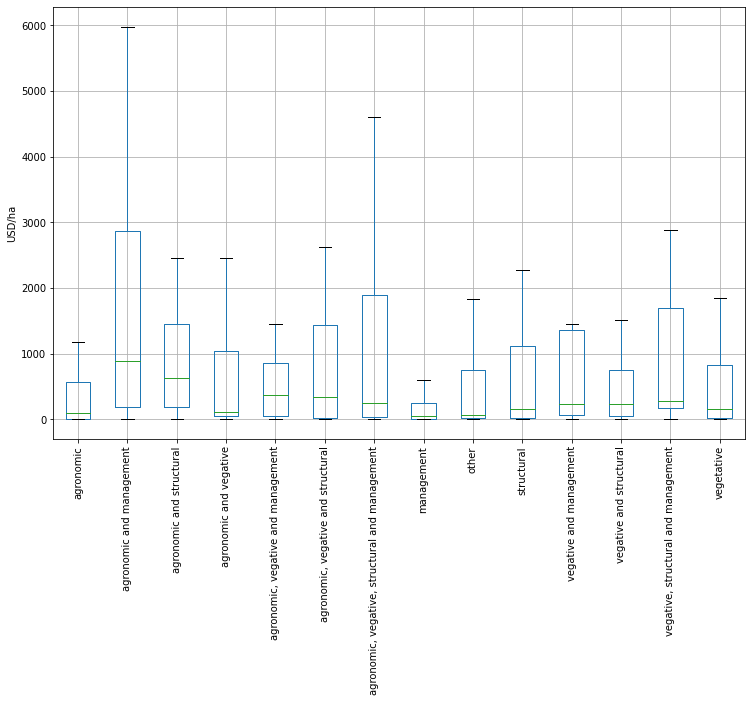

In [47]:
df.boxplot(column=['4_5_tech_input_est_total_costs_2020_usd_per_ha'], by='classified_measures', rot=90, showfliers=False)
plt.title('')
plt.suptitle('')
plt.xlabel('')
plt.ylabel('USD/ha')
# plt.savefig('Report/Figures/establishmentCostperHabyTypeofMeasureBoxplot.pdf', bbox_inches = "tight")
df.groupby(['classified_measures'])['4_5_tech_input_est_total_costs_2020_usd_per_ha'].describe()

,count,mean,std,min,25%,50%,75%,max
classified_measures,,,,,,,,
agronomic,75.0,146.213895,363.397403,0.0,0.009634,19.240388,134.506402,2098.839307
agronomic and management,22.0,270.046547,437.190716,0.0,0.000000,30.557333,319.807316,1405.783328
agronomic and structural,27.0,168.714912,209.714239,0.0,0.088940,84.941190,230.750880,846.611882
agronomic and vegative,35.0,105.926232,175.690870,0.0,1.198069,19.631311,108.073212,742.949896
"agronomic, vegative and management",23.0,173.054683,240.378426,0.0,0.109825,74.280636,259.702230,904.452647
"agronomic, vegative and structural",23.0,134.902246,194.990113,0.0,0.207294,10.357189,244.458263,649.955567
"agronomic, vegative, structural and management",41.0,94.145867,186.510026,0.0,0.237427,19.481560,86.644610,879.626528
management,26.0,177.436364,451.896964,0.0,0.106384,6.817872,102.646619,1968.292397
other,61.0,191.043243,470.210454,0.0,0.308140,8.980938,70.222632,2390.309667


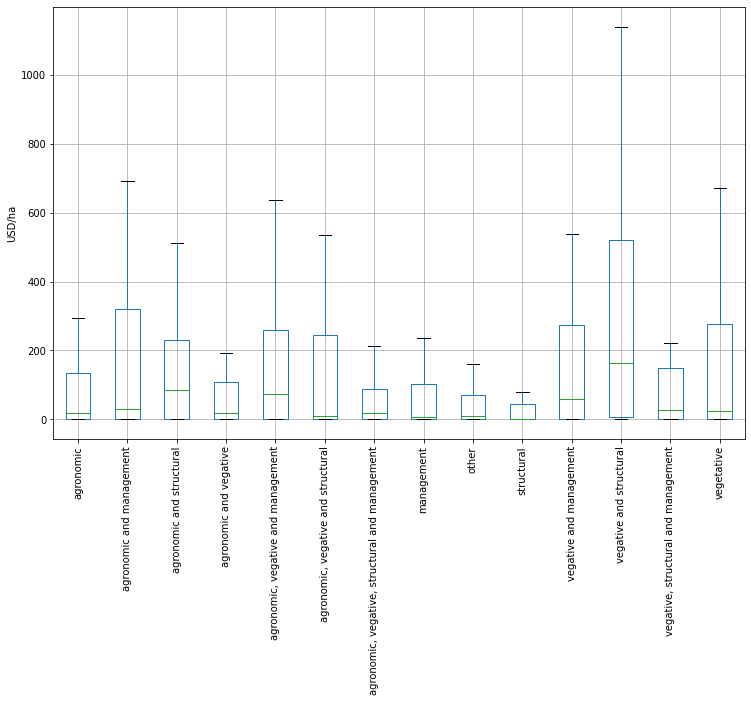

In [48]:
df.boxplot(column=['4_7_tech_input_maint_total_costs_2020_usd_per_ha'], by='classified_measures', rot=90, showfliers=False)
plt.title('')
plt.suptitle('')
plt.xlabel('')
plt.ylabel('USD/ha')
# plt.savefig('Report/Figures/maintenanceCostperHabyTypeofMeasureBoxplot.pdf', bbox_inches = "tight")
df.groupby(['classified_measures'])['4_7_tech_input_maint_total_costs_2020_usd_per_ha'].describe()

## Costs by Region


In [49]:
pd.options.display.float_format = '{:,.0f}'.format

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def percentage(x):
    return 100 * x / float(x.sum())

In [50]:
counts = df.groupby('Sub-region Name') \
        .agg(count=('code', 'count'),
             median_total_present_value_25=('total_present_values_2_5_per_ha', 'median'),
             median_est=('4_5_tech_input_est_total_costs_2020_usd_per_ha', 'median'),
             median_est_25=('4_5_tech_input_est_total_costs_2020_usd_per_ha', q25),
             median_est_75=('4_5_tech_input_est_total_costs_2020_usd_per_ha', q75),
             median_maint=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', 'median'),
             median_maint_25=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', q25),
             median_maint_75=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', q75),
             
        )

counts.insert(counts.columns.get_loc('median_total_present_value_25'), '(%)', (counts['count']/counts['count'].sum() * 100))


counts = counts.rename(columns={'count':'Count',
                         'median_est_25':'Est. Costs (25%)',
                         'median_est': 'Est. Costs (50%)',
                         'median_est_75':'Est. Costs (75%)',
                         'median_maint_25':'Maint. Costs (25%)',
                         'median_maint': 'Maint. Costs (50%)',
                         'median_maint_75':'Maint. Costs (75%)',
                         'median_total_present_value_25':'Median Total Present Value (2.5%)',
                        }) \
        .reset_index() \
        .sort_values(['Count'], ascending=False)
counts

# print(counts.to_latex(index=False))

,Sub-region Name,Count,(%),Median Total Present Value (2.5%),Est. Costs (50%),Est. Costs (25%),Est. Costs (75%),Maint. Costs (50%),Maint. Costs (25%),Maint. Costs (75%)
10,Sub-Saharan Africa,197,39,289,91,15,436,9,0,105
8,Southern Asia,62,12,"1,054",152,17,"1,071",12,0,211
7,South-eastern Asia,55,11,771,249,21,"1,589",34,1,273
1,Central Asia,53,10,644,121,17,764,24,0,172
9,Southern Europe,31,6,"2,858","1,508",199,"3,321",29,0,251
4,Latin America and the Caribbean,29,6,"1,892",482,163,"1,510",80,3,428
5,Northern Africa,24,5,813,342,99,"1,516",41,0,302
11,Western Asia,18,4,310,164,15,693,1,0,58
12,Western Europe,15,3,"4,273","1,233",108,"3,711",31,0,789
2,Eastern Asia,8,2,"4,035",573,170,"1,874",30,15,580


Text(0, 0.5, 'USD/ha')

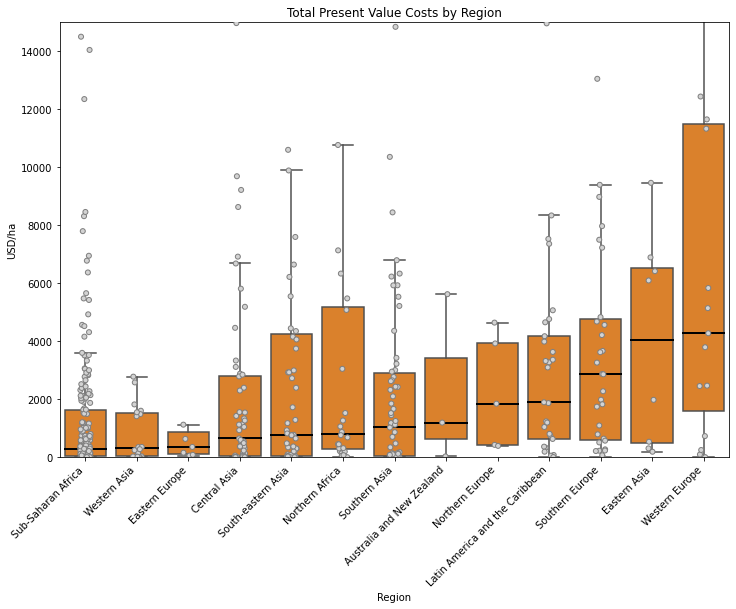

In [51]:
color = sns.light_palette("#47bf59", as_cmap=False)
sorted_index = df.groupby('Sub-region Name')["total_present_values_2_5_per_ha"].median().sort_values().index

fig, ax = plt.subplots()
ax = sns.boxplot(x="Sub-region Name", y="total_present_values_2_5_per_ha", data=df, 
                 showfliers=False, showbox=True, showcaps=True, 
                 whiskerprops={'visible': True}, medianprops = dict(linewidth=2, color='black'), 
                 color='#da812c', saturation=1,
                 order=sorted_index
                )# palette=color, 
ax = sns.stripplot(x="Sub-region Name", y="total_present_values_2_5_per_ha", data=df, 
                   linewidth=1, color='lightgrey',
                   order=sorted_index
                  )
# ax.set(ylim=1000)
ax.set_ylim(ymin=0, ymax=15000)
plt.xticks(rotation=45, ha="right")
plt.title('Total Present Value Costs by Region')
plt.xlabel('Region')
plt.ylabel('USD/ha')
# plt.savefig('Report/Figures/pvRegion.png', bbox_inches = "tight")


Text(0, 0.5, 'USD/ha')

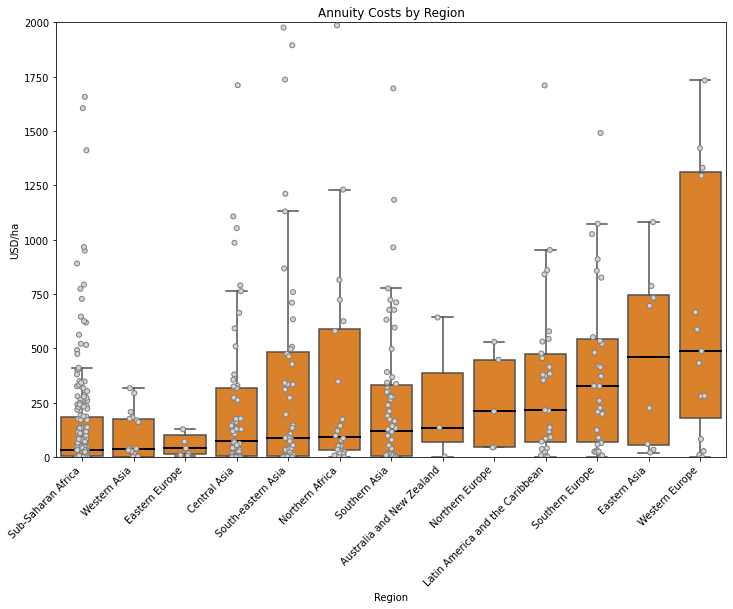

In [52]:
color = sns.light_palette("#47bf59", as_cmap=False)
sorted_index = df.groupby('Sub-region Name')["annuity_costs_2_5_per_ha"].median().sort_values().index

fig, ax = plt.subplots()
ax = sns.boxplot(x="Sub-region Name", y="annuity_costs_2_5_per_ha", data=df, 
                 showfliers=False, showbox=True, showcaps=True, 
                 whiskerprops={'visible': True}, medianprops = dict(linewidth=2, color='black'), 
                 color='#da812c', saturation=1,
                 order=sorted_index
                )# palette=color, 
ax = sns.stripplot(x="Sub-region Name", y="annuity_costs_2_5_per_ha", data=df, 
                   linewidth=1, color='lightgrey',
                   order=sorted_index
                  )
# ax.set(ylim=1000)
ax.set_ylim(ymin=0, ymax=2000)
plt.xticks(rotation=45, ha="right")
plt.title('Annuity Costs by Region')
plt.xlabel('Region')
plt.ylabel('USD/ha')
# plt.savefig('Report/Figures/annuity25Region.png', bbox_inches = "tight")


Text(86.99999999999999, 0.5, 'Benefits')

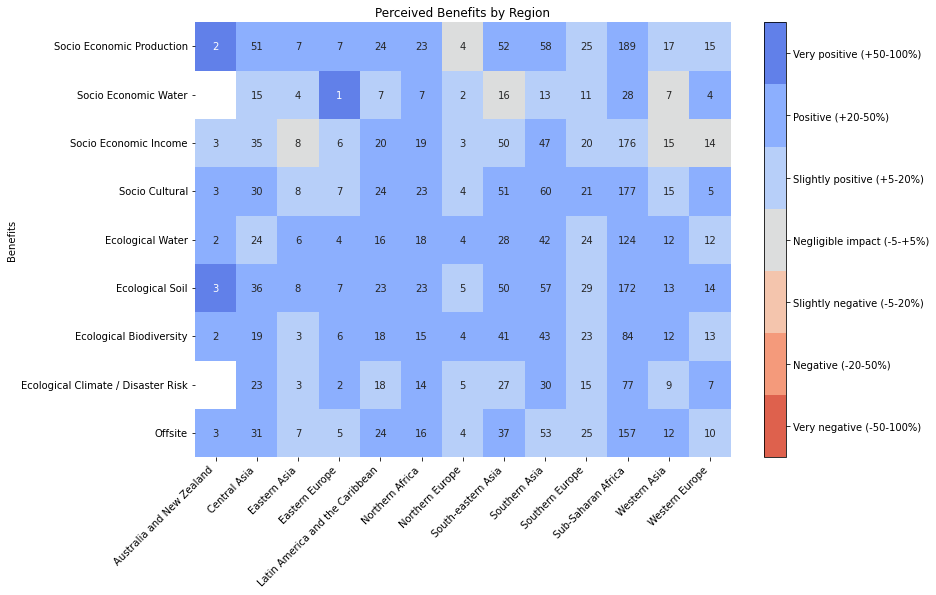

In [53]:
benefits_to_likert_list = [
    'Very negative (-50-100%)',
    'Negative (-20-50%)',
    'Slightly negative (-5-20%)',
    'Negligible impact (-5-+5%)',
    'Slightly positive (+5-20%)',
    'Positive (+20-50%)',
    'Very positive (+50-100%)'
]

benefits_summary = df.groupby('Sub-region Name')\
                    [[
                        'socio_economic_production_benefits_num',
                        'socio_economic_water_benefits_num',
                        'socio_economic_income_benefits_num',
                        'socio_cultural_benefits_num',
                        'ecological_water_benefits_num',
                        'ecological_soil_benefits_num',
                        'ecological_biodiversity_benefits_num',
                        'ecological_climate_disaster_risk_benefits_num',
                        'offsite_benefits_num'
                    ]].median().round(decimals=0).transpose()\
                        .rename(index={
                            'socio_economic_production_benefits_num': 'Socio Economic Production',
                            'socio_economic_water_benefits_num': 'Socio Economic Water',
                            'socio_economic_income_benefits_num': 'Socio Economic Income',
                            'socio_cultural_benefits_num': 'Socio Cultural',
                            'ecological_water_benefits_num': 'Ecological Water',
                            'ecological_soil_benefits_num': 'Ecological Soil',
                            'ecological_biodiversity_benefits_num': 'Ecological Biodiversity',
                            'ecological_climate_disaster_risk_benefits_num': 'Ecological Climate / Disaster Risk',
                            'offsite_benefits_num': 'Offsite',
                        })

benefits_summary_count = df.groupby('Sub-region Name')\
                    [[
                        'socio_economic_production_benefits_num',
                        'socio_economic_water_benefits_num',
                        'socio_economic_income_benefits_num',
                        'socio_cultural_benefits_num',
                        'ecological_water_benefits_num',
                        'ecological_soil_benefits_num',
                        'ecological_biodiversity_benefits_num',
                        'ecological_climate_disaster_risk_benefits_num',
                        'offsite_benefits_num'
                    ]].count().transpose()

color= sns.color_palette("coolwarm_r", 7)

fig, ax = plt.subplots()
ax = sns.heatmap(benefits_summary, vmin=-3, vmax=3, fmt='d', annot=benefits_summary_count, cmap=color, cbar=False)
plt.rcParams['axes.grid'] = False
# Get the colorbar object from the Seaborn heatmap
colorbar = fig.colorbar(ax.get_children()[0])
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
n = len(benefits_to_likert_list)
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(benefits_to_likert_list)
plt.xticks(rotation=45, ha="right")
plt.title('Perceived Benefits by Region')
plt.xlabel('')
plt.ylabel('Benefits')
# plt.savefig('Report/Figures/benefitsRegion.png', bbox_inches = "tight")

# benefits_summary

Text(86.99999999999999, 0.5, '')

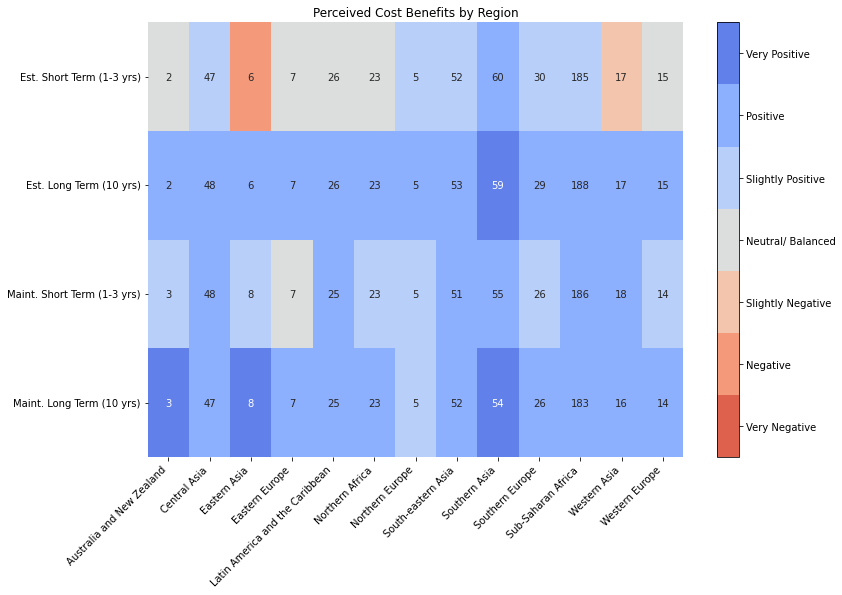

In [54]:
benefits_to_likert_list = [
    'Very Negative',
    'Negative',
    'Slightly Negative',
    'Neutral/ Balanced',
    'Slightly Positive',
    'Positive',
    'Very Positive'
]

cost_benefits_summary = df.groupby('Sub-region Name')\
                    [[
                        'tech_costbenefit_est_short_num',
                        'tech_costbenefit_est_long_num',
                        'tech_costbenefit_maint_short_num',
                        'tech_costbenefit_maint_long_num',
                    ]].median().round(decimals=0).transpose()\
                        .rename(index={
                            'tech_costbenefit_est_short_num': 'Est. Short Term (1-3 yrs)',
                            'tech_costbenefit_est_long_num': 'Est. Long Term (10 yrs)',
                            'tech_costbenefit_maint_short_num': 'Maint. Short Term (1-3 yrs)',
                            'tech_costbenefit_maint_long_num': 'Maint. Long Term (10 yrs)',
                        })

cost_benefits_summary_count = df.groupby('Sub-region Name')\
                    [[
                        'tech_costbenefit_est_short_num',
                        'tech_costbenefit_est_long_num',
                        'tech_costbenefit_maint_short_num',
                        'tech_costbenefit_maint_long_num',
                    ]].count().transpose()

color= sns.color_palette("coolwarm_r", 7)

fig, ax = plt.subplots()
ax = sns.heatmap(cost_benefits_summary, vmin=-3, vmax=3, fmt='d', annot=cost_benefits_summary_count, cmap=color, cbar=False)
plt.rcParams['axes.grid'] = False
# Get the colorbar object from the Seaborn heatmap
colorbar = fig.colorbar(ax.get_children()[0])
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
n = len(benefits_to_likert_list)
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(benefits_to_likert_list)
plt.xticks(rotation=45, ha="right")
plt.title('Perceived Cost Benefits by Region')
plt.xlabel('')
plt.ylabel('')
# plt.savefig('Report/Figures/costBenefitsRegion.png', bbox_inches = "tight")

# cost_benefits_summary

## Costs by Land Use


In [55]:
counts = df.groupby('land_use_summary') \
        .agg(count=('code', 'count'),
             median_total_present_value_25=('total_present_values_2_5_per_ha', 'median'),
             median_est=('4_5_tech_input_est_total_costs_2020_usd_per_ha', 'median'),
             median_est_25=('4_5_tech_input_est_total_costs_2020_usd_per_ha', q25),
             median_est_75=('4_5_tech_input_est_total_costs_2020_usd_per_ha', q75),
             median_maint=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', 'median'),
             median_maint_25=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', q25),
             median_maint_75=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', q75),
             
           ) \
        
counts.insert(counts.columns.get_loc('median_total_present_value_25'), '(%)', (counts['count']/counts['count'].sum() * 100))

counts = counts.rename(columns={'count':'Count',
                         'median_est_25':'Est. Costs (25%)',
                         'median_est': 'Est. Costs (50%)',
                         'median_est_75':'Est. Costs (75%)',
                         'median_maint_25':'Maint. Costs (25%)',
                         'median_maint': 'Maint. Costs (50%)',
                         'median_maint_75':'Maint. Costs (75%)',
                         'median_total_present_value_25':'Median Total Present Value (2.5%)',
                        }) \
        .reset_index() \
        .sort_values(['Count'], ascending=False)
counts

# print(counts.to_latex(index=False))

,land_use_summary,Count,(%),Median Total Present Value (2.5%),Est. Costs (50%),Est. Costs (25%),Est. Costs (75%),Maint. Costs (50%),Maint. Costs (25%),Maint. Costs (75%)
0,Cropland,220,43,763,162,7,962,26,0,156
2,"Cropland, Grazing land",78,15,502,158,24,"1,100",20,0,170
3,"Cropland, Grazing land, Forest/ woodlands",55,11,329,83,18,356,21,2,165
5,Grazing land,42,8,317,253,17,634,0,0,18
1,"Cropland, Forest/ woodlands",41,8,"1,553",410,51,"1,688",84,7,259
4,Forest/ woodlands,26,5,"2,689",498,140,"1,634",55,1,347
6,"Grazing land, Forest/ woodlands",17,3,226,191,99,700,1,0,14
8,Other mixed land uses,11,2,289,55,26,362,7,0,54
9,Restoring unproductive lands,10,2,"1,646","1,485",117,"3,619",1,0,345
7,Not Documented,3,1,"6,370","1,190",778,"3,218",650,362,771


Text(0, 0.5, 'USD/ha')

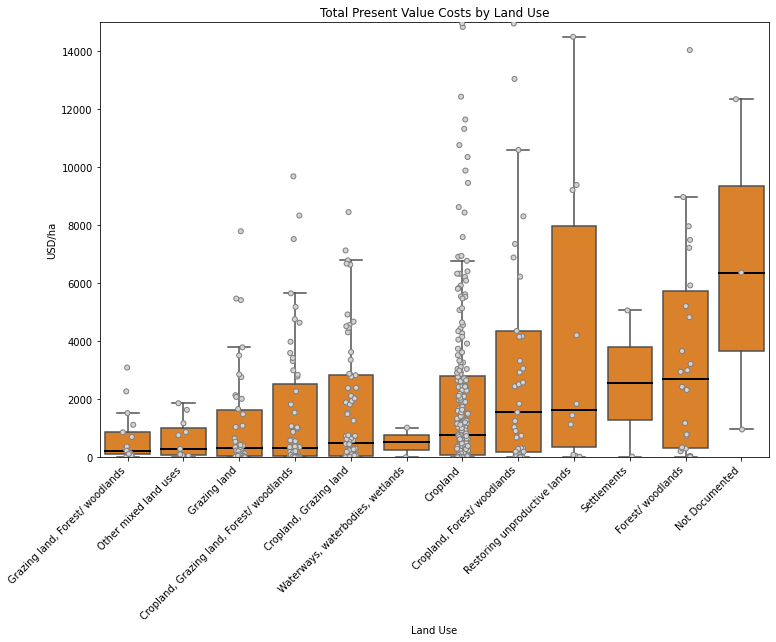

In [56]:
sorted_index = df.groupby('land_use_summary')["total_present_values_2_5_per_ha"].median().sort_values().index

fig, ax = plt.subplots()
ax = sns.boxplot(x="land_use_summary", y="total_present_values_2_5_per_ha", data=df, 
                 showfliers=False, showbox=True, showcaps=True, 
                 whiskerprops={'visible': True}, medianprops = dict(linewidth=2, color='black'), 
                 color='#da812c', saturation=1,
                 order=sorted_index
                )# palette=color, 
ax = sns.stripplot(x="land_use_summary", y="total_present_values_2_5_per_ha", data=df, 
                   linewidth=1, color='lightgrey',
                   order=sorted_index
                  )
# ax.set(ylim=1000)
ax.set_ylim(ymin=0, ymax=15000)
plt.xticks(rotation=45, ha="right")
plt.title('Total Present Value Costs by Land Use')
plt.xlabel('Land Use')
plt.ylabel('USD/ha')
# plt.savefig('Report/Figures/pvLanduse.png', bbox_inches = "tight")


Text(0, 0.5, 'USD/ha')

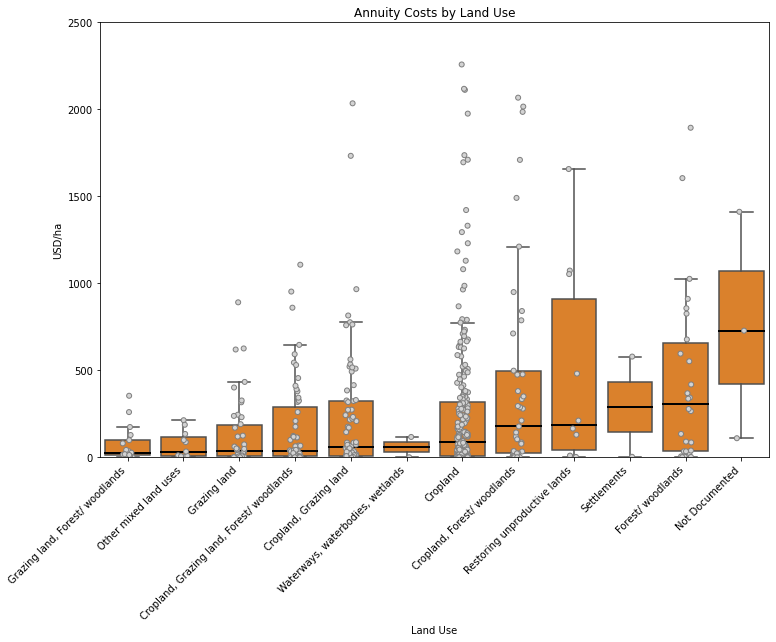

In [57]:
sorted_index = df.groupby('land_use_summary')["annuity_costs_2_5_per_ha"].median().sort_values().index

fig, ax = plt.subplots()
ax = sns.boxplot(x="land_use_summary", y="annuity_costs_2_5_per_ha", data=df, 
                 showfliers=False, showbox=True, showcaps=True, 
                 whiskerprops={'visible': True}, medianprops = dict(linewidth=2, color='black'), 
                 color='#da812c', saturation=1,
                 order=sorted_index
                )# palette=color, 
ax = sns.stripplot(x="land_use_summary", y="annuity_costs_2_5_per_ha", data=df, 
                   linewidth=1, color='lightgrey',
                   order=sorted_index
                  )
# ax.set(ylim=1000)
ax.set_ylim(ymin=0, ymax=2500)
plt.xticks(rotation=45, ha="right")
plt.title('Annuity Costs by Land Use')
plt.xlabel('Land Use')
plt.ylabel('USD/ha')
# plt.savefig('Report/Figures/annuity25Landuse.png', bbox_inches = "tight")


Text(86.99999999999999, 0.5, 'Benefits')

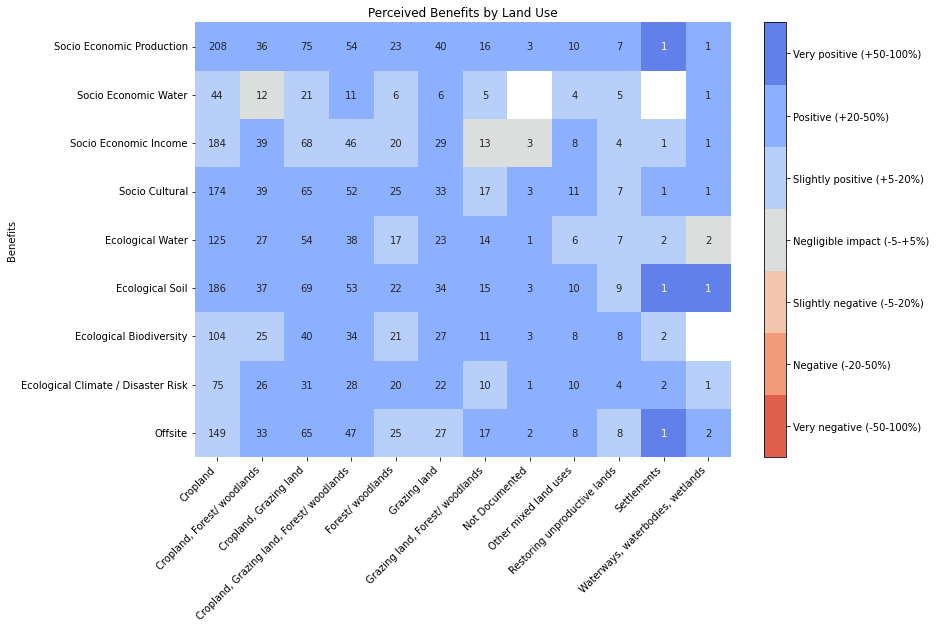

In [58]:
benefits_to_likert_list = [
    'Very negative (-50-100%)',
    'Negative (-20-50%)',
    'Slightly negative (-5-20%)',
    'Negligible impact (-5-+5%)',
    'Slightly positive (+5-20%)',
    'Positive (+20-50%)',
    'Very positive (+50-100%)'
]

benefits_summary = df.groupby('land_use_summary')\
                    [[
                        'socio_economic_production_benefits_num',
                        'socio_economic_water_benefits_num',
                        'socio_economic_income_benefits_num',
                        'socio_cultural_benefits_num',
                        'ecological_water_benefits_num',
                        'ecological_soil_benefits_num',
                        'ecological_biodiversity_benefits_num',
                        'ecological_climate_disaster_risk_benefits_num',
                        'offsite_benefits_num'
                    ]].median().round(decimals=0).transpose()\
                        .rename(index={
                            'socio_economic_production_benefits_num': 'Socio Economic Production',
                            'socio_economic_water_benefits_num': 'Socio Economic Water',
                            'socio_economic_income_benefits_num': 'Socio Economic Income',
                            'socio_cultural_benefits_num': 'Socio Cultural',
                            'ecological_water_benefits_num': 'Ecological Water',
                            'ecological_soil_benefits_num': 'Ecological Soil',
                            'ecological_biodiversity_benefits_num': 'Ecological Biodiversity',
                            'ecological_climate_disaster_risk_benefits_num': 'Ecological Climate / Disaster Risk',
                            'offsite_benefits_num': 'Offsite',
                        })

benefits_summary_count = df.groupby('land_use_summary')\
                    [[
                        'socio_economic_production_benefits_num',
                        'socio_economic_water_benefits_num',
                        'socio_economic_income_benefits_num',
                        'socio_cultural_benefits_num',
                        'ecological_water_benefits_num',
                        'ecological_soil_benefits_num',
                        'ecological_biodiversity_benefits_num',
                        'ecological_climate_disaster_risk_benefits_num',
                        'offsite_benefits_num'
                    ]].count().transpose()

# color= sns.light_palette("#da812c", 7)
color= sns.color_palette("coolwarm_r", 7)

fig, ax = plt.subplots()
ax = sns.heatmap(benefits_summary, vmin=-3, vmax=3, fmt='d', annot=benefits_summary_count, cmap=color, cbar=False) #cbar_kws={"ticklabels":benefits_to_likert_list}
plt.rcParams['axes.grid'] = False
# Get the colorbar object from the Seaborn heatmap
colorbar = fig.colorbar(ax.get_children()[0])
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
n = len(benefits_to_likert_list)
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(benefits_to_likert_list)
plt.xticks(rotation=45, ha="right")
plt.title('Perceived Benefits by Land Use')
plt.xlabel('')
plt.ylabel('Benefits')
# plt.savefig('Report/Figures/benefitsLanduse.png', bbox_inches = "tight")

# benefits_summary

Text(86.99999999999999, 0.5, '')

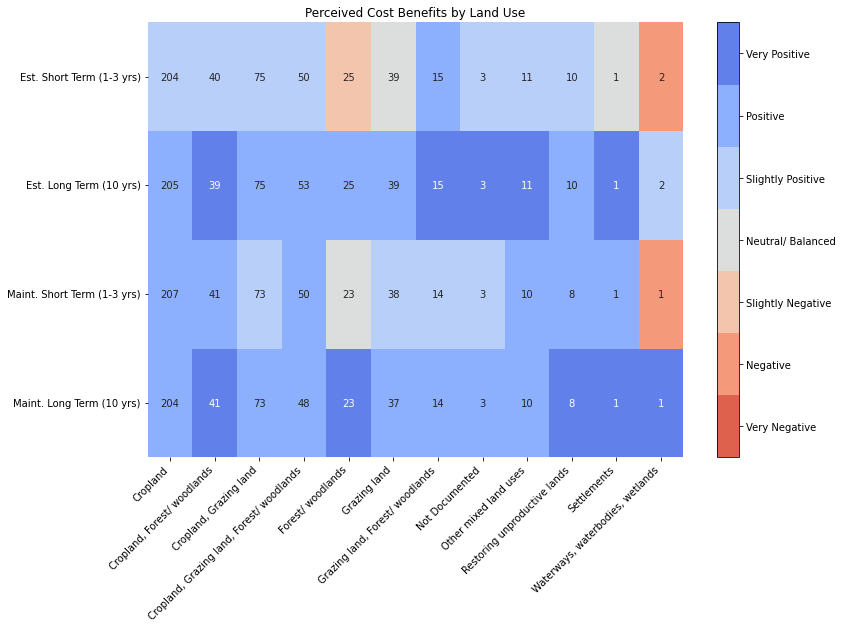

In [59]:
benefits_to_likert_list = [
    'Very Negative',
    'Negative',
    'Slightly Negative',
    'Neutral/ Balanced',
    'Slightly Positive',
    'Positive',
    'Very Positive'
]

cost_benefits_summary = df.groupby('land_use_summary')\
                    [[
                        'tech_costbenefit_est_short_num',
                        'tech_costbenefit_est_long_num',
                        'tech_costbenefit_maint_short_num',
                        'tech_costbenefit_maint_long_num',
                    ]].median().round(decimals=0).transpose()\
                        .rename(index={
                            'tech_costbenefit_est_short_num': 'Est. Short Term (1-3 yrs)',
                            'tech_costbenefit_est_long_num': 'Est. Long Term (10 yrs)',
                            'tech_costbenefit_maint_short_num': 'Maint. Short Term (1-3 yrs)',
                            'tech_costbenefit_maint_long_num': 'Maint. Long Term (10 yrs)',
                        })

cost_benefits_summary_count = df.groupby('land_use_summary')\
                    [[
                        'tech_costbenefit_est_short_num',
                        'tech_costbenefit_est_long_num',
                        'tech_costbenefit_maint_short_num',
                        'tech_costbenefit_maint_long_num',
                    ]].count().transpose()

# color= sns.light_palette("#da812c", 7)
color= sns.color_palette("coolwarm_r", 7)

fig, ax = plt.subplots()
ax = sns.heatmap(cost_benefits_summary, vmin=-3, vmax=3, fmt='d', annot=cost_benefits_summary_count, cmap=color, cbar=False)
plt.rcParams['axes.grid'] = False
# Get the colorbar object from the Seaborn heatmap
colorbar = fig.colorbar(ax.get_children()[0])
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
n = len(benefits_to_likert_list)
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(benefits_to_likert_list)
plt.xticks(rotation=45, ha="right")
plt.title('Perceived Cost Benefits by Land Use')
plt.xlabel('')
plt.ylabel('')
# plt.savefig('Report/Figures/costBenefitsLanduse.png', bbox_inches = "tight")

# cost_benefits_summary

## Costs by SLM Group


In [60]:
counts = df.groupby('slm_group_remapped') \
        .agg(
             median_total_present_value_25=('total_present_values_2_5_per_ha', 'median'),
             median_est=('4_5_tech_input_est_total_costs_2020_usd_per_ha', 'median'),
             median_est_25=('4_5_tech_input_est_total_costs_2020_usd_per_ha', q25),
             median_est_75=('4_5_tech_input_est_total_costs_2020_usd_per_ha', q75),
             median_maint=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', 'median'),
             median_maint_25=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', q25),
             median_maint_75=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', q75),
             count=('code', 'count'),
             
           ) \
        
# counts.insert(counts.columns.get_loc('median_total_present_value_25'), '(%)', (counts['count']/counts['count'].sum() * 100))
percent = pd.Series((counts['count']/counts['count'].sum() * 100), name='percent',)
counts = pd.concat([counts, percent], axis=1).sort_values(['count'], ascending=False)

counts = pd.concat([counts['median_total_present_value_25'],
            counts.loc[:,['median_est', 'median_est_25', 'median_est_75']],
            counts.loc[:, ['median_maint', 'median_maint_25', 'median_maint_75']],
            counts.loc[:,['count', 'percent']]
          ], keys=['PV Costs', 
                          'Establishment Costs',
                          'Maintenance Costs',
                          'Summary',
                         ], axis=1)
counts
# counts.to_clipboard()

# counts = counts.rename(columns={'count':'Count',
#                          'median_est_25':'Est. Costs (25%)',
#                          'median_est': 'Est. Costs (50%)',
#                          'median_est_75':'Est. Costs (75%)',
#                          'median_maint_25':'Maint. Costs (25%)',
#                          'median_maint': 'Maint. Costs (50%)',
#                          'median_maint_75':'Maint. Costs (75%)',
#                          'median_total_present_value_25':'Median Total Present Value (2.5%)',
#                         }) \
#         .reset_index() \
#         .sort_values(['Count'], ascending=False)
# counts

# print(counts.to_latex(index=False))

PV Costs  \
                                     median_total_present_value_25   
slm_group_remapped                                                   
Improved ground cover                                          787   
Agroforestry                                                 1,176   
Terraces and bunds                                             135   
Forest management                                            1,913   
Crop rotational systems                                      1,683   
Irrigation and water management                                442   
Protected areas                                                700   
Grazing land management                                        173   
Integrated soil fertility management                           633   
Water harvesting                                               414   
Miscellaneous                                                1,561   
Minimum tillage                                                644   
Integrated crop-livestock management                         2,510   

                                     Establishment Costs                \
                                              median_est median_est_25   
slm_group_remapped                                                       
Improved ground cover                                226            32   
Agroforestry                                         285            46   
Terraces and bunds                                    60            18   
Forest management                                    427            47   
Crop rotational systems                              241            16   
Irrigation and water management                      139            14   
Protected areas                                      274            50   
Grazing land management                               69            21   
Integrated soil fertility management                 141            13   
Water harvesting                                     199            18   
Miscellaneous                                        238            11   
Minimum tillage                                       47             1   
Integrated crop-livestock management               1,638           107   

                                                   Maintenance Costs  \
                                     median_est_75      median_maint   
slm_group_remapped                                                     
Improved ground cover                        1,109                20   
Agroforestry                                   973                84   
Terraces and bunds                             253                 7   
Forest management                            1,327                62   
Crop rotational systems                      1,466                60   
Irrigation and water management              1,121                 1   
Protected areas                              1,447                19   
Grazing land management                        428                 0   
Integrated soil fertility management           547                34   
Water harvesting                               691                12   
Miscellaneous                                2,502                 7   
Minimum tillage                                758                 4   
Integrated crop-livestock management         6,991                98   

                                                                     Summary  \
                                     median_maint_25 median_maint_75   count   
slm_group_remapped                                                             
Improved ground cover                              0             140      89   
Agroforestry                                       5             359      75   
Terraces and bunds                                 0              37      70   
Forest management                                  1             377      50   
Crop rotational systems                

In [61]:
counts = df.groupby('slm_group_remapped') \
        .agg(count=('code', 'count'),
             median_total_present_value_25=('total_present_values_2_5_per_ha', 'median'),
             median_est=('4_5_tech_input_est_total_costs_2020_usd_per_ha', 'median'),
             median_est_25=('4_5_tech_input_est_total_costs_2020_usd_per_ha', q25),
             median_est_75=('4_5_tech_input_est_total_costs_2020_usd_per_ha', q75),
             median_maint=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', 'median'),
             median_maint_25=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', q25),
             median_maint_75=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', q75),
             
           ) \
        
counts.insert(counts.columns.get_loc('median_total_present_value_25'), '(%)', (counts['count']/counts['count'].sum() * 100))

counts = counts.rename(columns={'count':'Count',
                         'median_est_25':'Est. Costs (25%)',
                         'median_est': 'Est. Costs (50%)',
                         'median_est_75':'Est. Costs (75%)',
                         'median_maint_25':'Maint. Costs (25%)',
                         'median_maint': 'Maint. Costs (50%)',
                         'median_maint_75':'Maint. Costs (75%)',
                         'median_total_present_value_25':'Median Total Present Value (2.5%)',
                        }) \
        .reset_index() \
        .sort_values(['Count'], ascending=False)
counts

# print(counts.to_latex(index=False))

,slm_group_remapped,Count,(%),Median Total Present Value (2.5%),Est. Costs (50%),Est. Costs (25%),Est. Costs (75%),Maint. Costs (50%),Maint. Costs (25%),Maint. Costs (75%)
4,Improved ground cover,89,18,787,226,32,"1,109",20,0,140
0,Agroforestry,75,15,"1,176",285,46,973,84,5,359
11,Terraces and bunds,70,14,135,60,18,253,7,0,37
2,Forest management,50,10,"1,913",427,47,"1,327",62,1,377
1,Crop rotational systems,39,8,"1,683",241,16,"1,466",60,4,623
7,Irrigation and water management,32,6,442,139,14,"1,121",1,0,55
10,Protected areas,29,6,700,274,50,"1,447",19,0,77
3,Grazing land management,28,6,173,69,21,428,0,0,17
6,Integrated soil fertility management,22,4,633,141,13,547,34,0,154
12,Water harvesting,22,4,414,199,18,691,12,0,40


Text(0, 0.5, 'USD/ha')

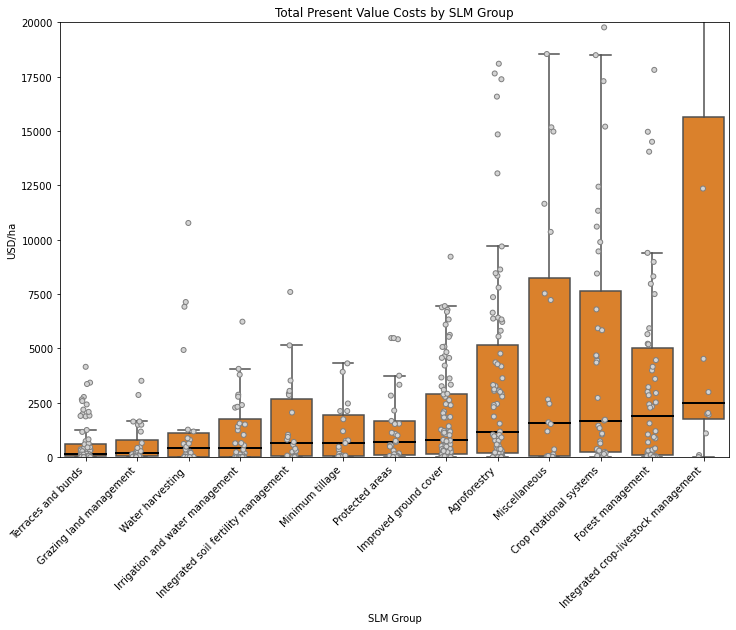

In [62]:
sorted_index = df.groupby('slm_group_remapped')["total_present_values_2_5_per_ha"].median().sort_values().index

fig, ax = plt.subplots()
ax = sns.boxplot(x="slm_group_remapped", y="total_present_values_2_5_per_ha", data=df, 
                 showfliers=False, showbox=True, showcaps=True, 
                 whiskerprops={'visible': True}, medianprops = dict(linewidth=2, color='black'), 
                 color='#da812c', saturation=1,
                 order=sorted_index
                )# palette=color, 
ax = sns.stripplot(x="slm_group_remapped", y="total_present_values_2_5_per_ha", data=df, 
                   linewidth=1, color='lightgrey',
                   order=sorted_index
                  )
# ax.set(ylim=1000)
ax.set_ylim(ymin=0, ymax=20000)
plt.xticks(rotation=45, ha="right")
plt.title('Total Present Value Costs by SLM Group')
plt.xlabel('SLM Group')
plt.ylabel('USD/ha')
# plt.savefig('Report/Figures/pvSLMGroup.png', bbox_inches = "tight")


Text(0, 0.5, 'USD/ha')

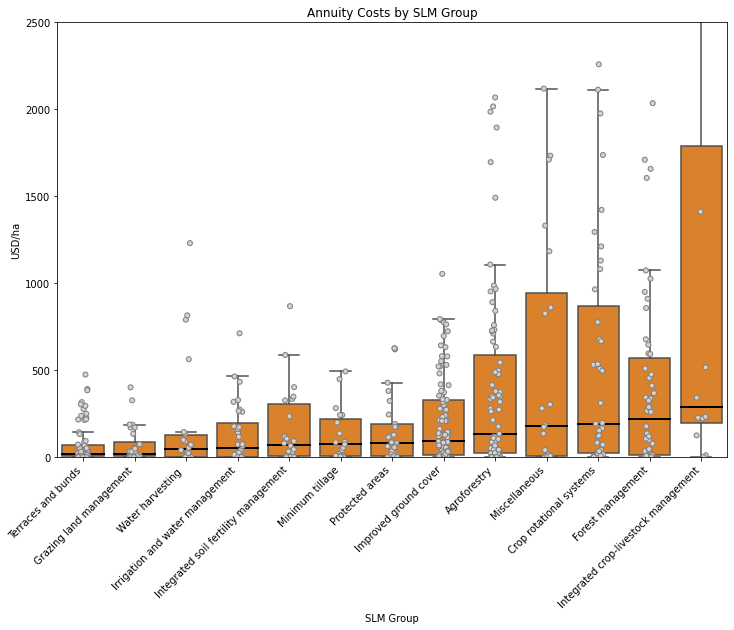

In [63]:
sorted_index = df.groupby('slm_group_remapped')["annuity_costs_2_5_per_ha"].median().sort_values().index

fig, ax = plt.subplots()
ax = sns.boxplot(x="slm_group_remapped", y="annuity_costs_2_5_per_ha", data=df, 
                 showfliers=False, showbox=True, showcaps=True, 
                 whiskerprops={'visible': True}, medianprops = dict(linewidth=2, color='black'), 
                 color='#da812c', saturation=1,
                 order=sorted_index
                )# palette=color, 
ax = sns.stripplot(x="slm_group_remapped", y="annuity_costs_2_5_per_ha", data=df, 
                   linewidth=1, color='lightgrey',
                   order=sorted_index
                  )
# ax.set(ylim=1000)
ax.set_ylim(ymin=0, ymax=2500)
plt.xticks(rotation=45, ha="right")
plt.title('Annuity Costs by SLM Group')
plt.xlabel('SLM Group')
plt.ylabel('USD/ha')
# plt.savefig('Report/Figures/annuitySLMGroup.png', bbox_inches = "tight")


Text(86.99999999999999, 0.5, 'Benefits')

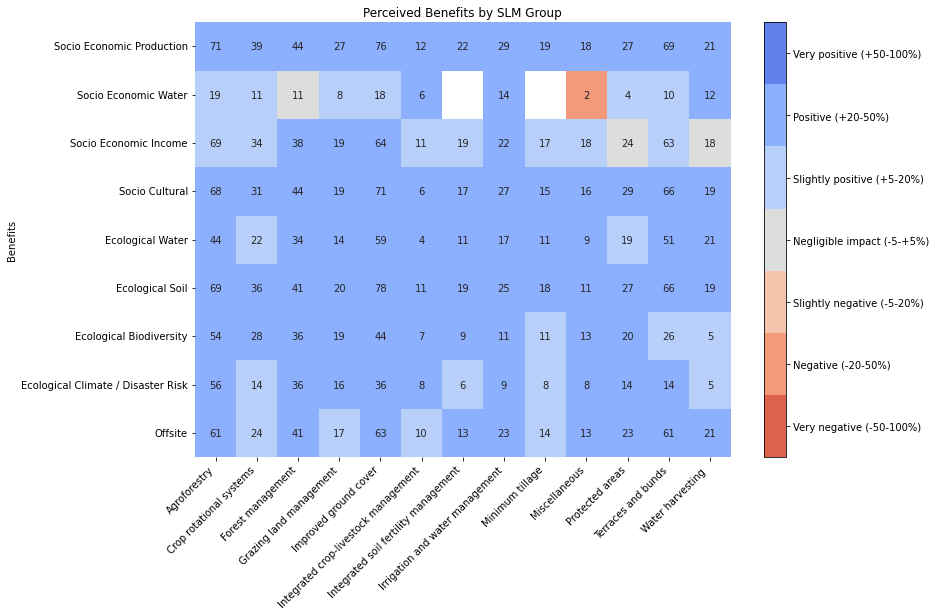

In [64]:
benefits_to_likert_list = [
    'Very negative (-50-100%)',
    'Negative (-20-50%)',
    'Slightly negative (-5-20%)',
    'Negligible impact (-5-+5%)',
    'Slightly positive (+5-20%)',
    'Positive (+20-50%)',
    'Very positive (+50-100%)'
]

benefits_summary = df.groupby('slm_group_remapped')\
                    [[
                        'socio_economic_production_benefits_num',
                        'socio_economic_water_benefits_num',
                        'socio_economic_income_benefits_num',
                        'socio_cultural_benefits_num',
                        'ecological_water_benefits_num',
                        'ecological_soil_benefits_num',
                        'ecological_biodiversity_benefits_num',
                        'ecological_climate_disaster_risk_benefits_num',
                        'offsite_benefits_num'
                    ]].median().round(decimals=0).transpose()\
                        .rename(index={
                            'socio_economic_production_benefits_num': 'Socio Economic Production',
                            'socio_economic_water_benefits_num': 'Socio Economic Water',
                            'socio_economic_income_benefits_num': 'Socio Economic Income',
                            'socio_cultural_benefits_num': 'Socio Cultural',
                            'ecological_water_benefits_num': 'Ecological Water',
                            'ecological_soil_benefits_num': 'Ecological Soil',
                            'ecological_biodiversity_benefits_num': 'Ecological Biodiversity',
                            'ecological_climate_disaster_risk_benefits_num': 'Ecological Climate / Disaster Risk',
                            'offsite_benefits_num': 'Offsite',
                        })

benefits_summary_count = df.groupby('slm_group_remapped')\
                    [[
                        'socio_economic_production_benefits_num',
                        'socio_economic_water_benefits_num',
                        'socio_economic_income_benefits_num',
                        'socio_cultural_benefits_num',
                        'ecological_water_benefits_num',
                        'ecological_soil_benefits_num',
                        'ecological_biodiversity_benefits_num',
                        'ecological_climate_disaster_risk_benefits_num',
                        'offsite_benefits_num'
                    ]].count().transpose()

color= sns.color_palette("coolwarm_r", 7)

fig, ax = plt.subplots()
ax = sns.heatmap(benefits_summary, vmin=-3, vmax=3, fmt='d', annot=benefits_summary_count, cmap=color, cbar=False) #cbar_kws={"ticklabels":benefits_to_likert_list}
plt.rcParams['axes.grid'] = False
# Get the colorbar object from the Seaborn heatmap
colorbar = fig.colorbar(ax.get_children()[0])
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
n = len(benefits_to_likert_list)
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(benefits_to_likert_list)
plt.xticks(rotation=45, ha="right")
plt.title('Perceived Benefits by SLM Group')
plt.xlabel('')
plt.ylabel('Benefits')
# plt.savefig('Report/Figures/benefitsSLMGroup.png', bbox_inches = "tight")

# benefits_summary

Text(86.99999999999999, 0.5, '')

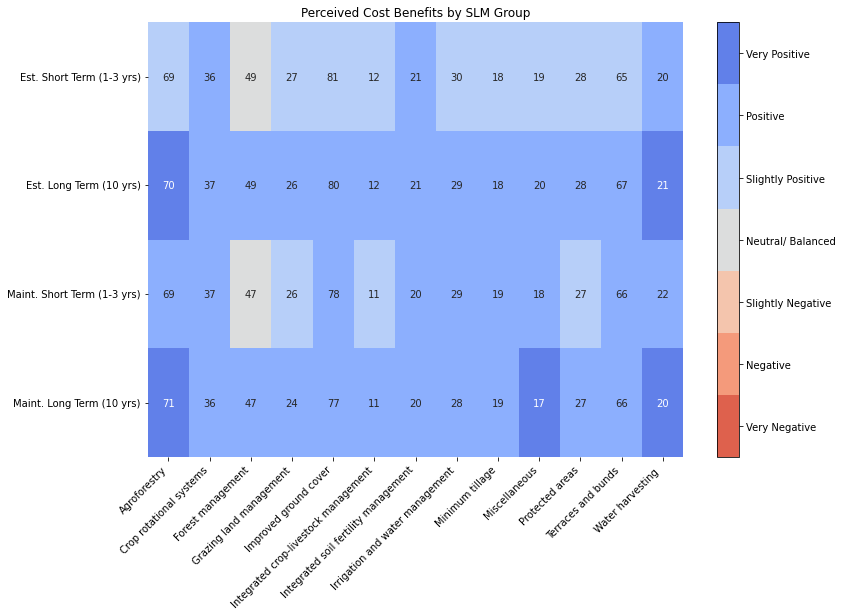

In [65]:
benefits_to_likert_list = [
    'Very Negative',
    'Negative',
    'Slightly Negative',
    'Neutral/ Balanced',
    'Slightly Positive',
    'Positive',
    'Very Positive'
]

cost_benefits_summary = df.groupby('slm_group_remapped')\
                    [[
                        'tech_costbenefit_est_short_num',
                        'tech_costbenefit_est_long_num',
                        'tech_costbenefit_maint_short_num',
                        'tech_costbenefit_maint_long_num',
                    ]].median().round(decimals=0).transpose()\
                        .rename(index={
                            'tech_costbenefit_est_short_num': 'Est. Short Term (1-3 yrs)',
                            'tech_costbenefit_est_long_num': 'Est. Long Term (10 yrs)',
                            'tech_costbenefit_maint_short_num': 'Maint. Short Term (1-3 yrs)',
                            'tech_costbenefit_maint_long_num': 'Maint. Long Term (10 yrs)',
                        })

cost_benefits_summary_count = df.groupby('slm_group_remapped')\
                    [[
                        'tech_costbenefit_est_short_num',
                        'tech_costbenefit_est_long_num',
                        'tech_costbenefit_maint_short_num',
                        'tech_costbenefit_maint_long_num',
                    ]].count().transpose()

color= sns.color_palette("coolwarm_r", 7)

fig, ax = plt.subplots()
ax = sns.heatmap(cost_benefits_summary, vmin=-3, vmax=3, fmt='d', annot=cost_benefits_summary_count, cmap=color, cbar=False)
plt.rcParams['axes.grid'] = False
# Get the colorbar object from the Seaborn heatmap
colorbar = fig.colorbar(ax.get_children()[0])
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
n = len(benefits_to_likert_list)
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(benefits_to_likert_list)
plt.xticks(rotation=45, ha="right")
plt.title('Perceived Cost Benefits by SLM Group')
plt.xlabel('')
plt.ylabel('')
# plt.savefig('Report/Figures/costBenefitsSLMGroup.png', bbox_inches = "tight")

# cost_benefits_summary

## Total Present Value Costs


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'Terraces and bunds'),
  Text(1, 0, 'Grazing land management'),
  Text(2, 0, 'Water harvesting '),
  Text(3, 0, 'Irrigation and water management'),
  Text(4, 0, 'Integrated soil fertility management'),
  Text(5, 0, 'Minimum tillage'),
  Text(6, 0, 'Protected areas'),
  Text(7, 0, 'Improved ground cover'),
  Text(8, 0, 'Agroforestry'),
  Text(9, 0, 'Miscellaneous'),
  Text(10, 0, 'Crop rotational systems'),
  Text(11, 0, 'Forest management'),
  Text(12, 0, 'Integrated crop-livestock management')])

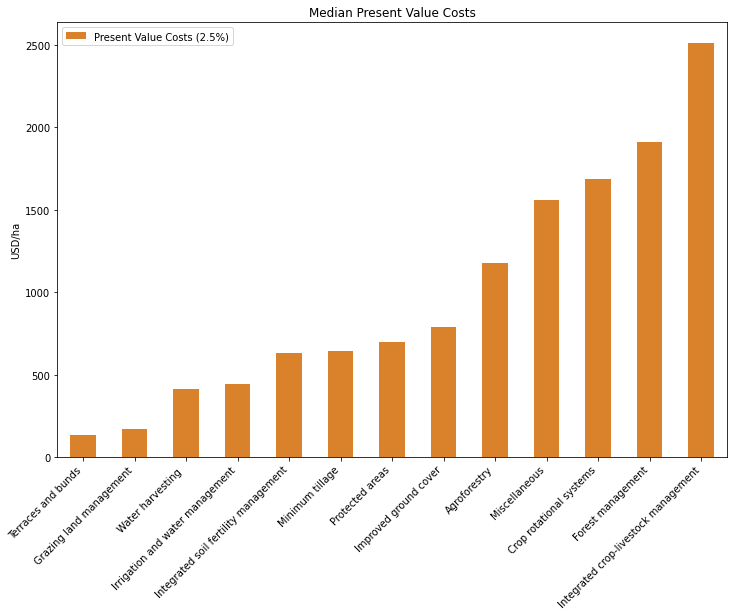

In [66]:
color= sns.color_palette("coolwarm",1)
median_costs = df.groupby('slm_group_remapped')[['total_present_values_2_5_per_ha']].median()\
    .sort_values('total_present_values_2_5_per_ha', ascending=True)\
    .rename(columns={'total_present_values_2_5_per_ha': 'Present Value Costs (2.5%)'})
median_costs.plot.bar(color='#da812c')
plt.ylabel('USD/ha')
plt.xlabel('')
plt.title('Median Present Value Costs')
plt.xticks(rotation=45, ha="right")
# plt.savefig('Report/Figures/presentValueBreakdownBySLMGroup.png', bbox_inches = "tight")

## Combined Est. and Maint. Costs by SLM Group

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'Minimum tillage'),
  Text(1, 0, 'Terraces and bunds'),
  Text(2, 0, 'Grazing land management'),
  Text(3, 0, 'Irrigation and water management'),
  Text(4, 0, 'Integrated soil fertility management'),
  Text(5, 0, 'Water harvesting '),
  Text(6, 0, 'Improved ground cover'),
  Text(7, 0, 'Miscellaneous'),
  Text(8, 0, 'Crop rotational systems'),
  Text(9, 0, 'Protected areas'),
  Text(10, 0, 'Agroforestry'),
  Text(11, 0, 'Forest management'),
  Text(12, 0, 'Integrated crop-livestock management')])

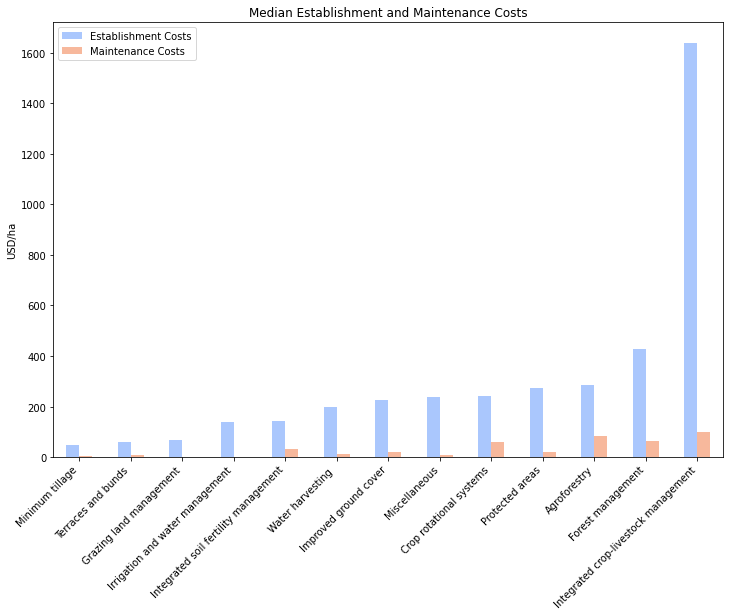

In [67]:
color= sns.color_palette("coolwarm",2)
median_costs = df.groupby('slm_group_remapped')[['4_5_tech_input_est_total_costs_2020_usd_per_ha', '4_7_tech_input_maint_total_costs_2020_usd_per_ha']].median()\
    .sort_values('4_5_tech_input_est_total_costs_2020_usd_per_ha', ascending=True)\
    .rename(columns={'4_5_tech_input_est_total_costs_2020_usd_per_ha': 'Establishment Costs', '4_7_tech_input_maint_total_costs_2020_usd_per_ha': 'Maintenance Costs'})
median_costs.plot.bar(color=color)
plt.ylabel('USD/ha')
plt.xlabel('')
plt.title('Median Establishment and Maintenance Costs')
plt.xticks(rotation=45, ha="right")
# plt.savefig('Report/Figures/combinedBreakdownBySLMGroup.png', bbox_inches = "tight")


## Est Costs Breakdown by SLM Group

,Labour,Equipment,Plant Materials,Fertilizer and Biocides,Construction Materials,Other
slm_group_remapped,,,,,,
Forest management,153,28,9,0,0,0
Water harvesting,109,1,0,0,2,0
Protected areas,91,12,0,0,0,0
Agroforestry,65,3,70,0,0,0
Improved ground cover,38,12,6,0,0,0
Miscellaneous,34,0,0,0,0,0
Irrigation and water management,31,0,0,0,0,0
Terraces and bunds,29,3,1,0,0,0
Integrated soil fertility management,28,0,0,0,0,0


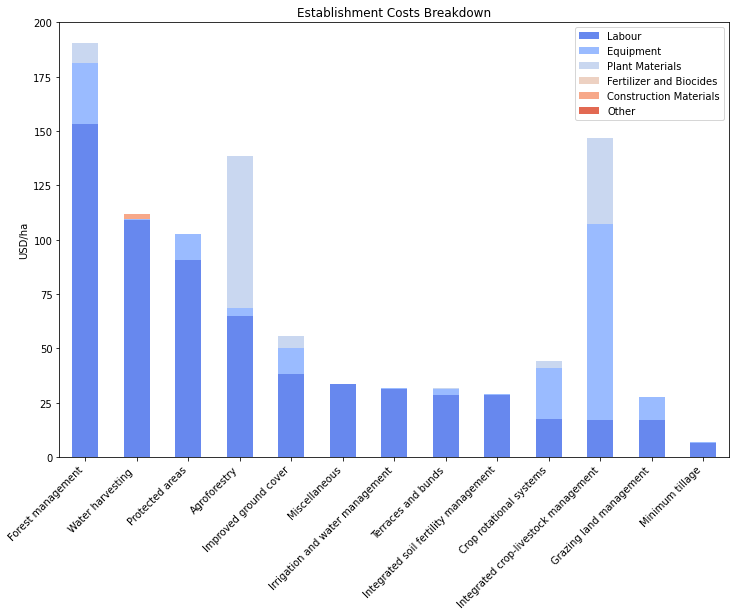

In [68]:
breakdown_median_est = pd.DataFrame(df.loc[:, ['code', 'slm_group_remapped', 'labour_est_per_ha', 'equipment_est_per_ha', 'plant_est_per_ha', 'fertilizer_est_per_ha', 'construction_est_per_ha', 'other_est_per_ha']].groupby('slm_group_remapped').median()).sort_values(by='labour_est_per_ha', ascending=False)
breakdown_median_est.rename({'labour_est_per_ha': 'Labour', 'equipment_est_per_ha': 'Equipment', 'plant_est_per_ha': 'Plant Materials', 'fertilizer_est_per_ha': 'Fertilizer and Biocides', 'construction_est_per_ha': 'Construction Materials', 'other_est_per_ha': 'Other'}, axis=1, inplace=True)
color= sns.color_palette("coolwarm",6)
breakdown_median_est.plot.bar(stacked=True, color=color)
plt.ylabel('USD/ha')
plt.xlabel('')
plt.title('Establishment Costs Breakdown')
plt.xticks(rotation=45, ha="right")
# plt.savefig('Report/Figures/estMedianBreakdownBySLMGroup.png', bbox_inches = "tight")
# print(breakdown_median_est.to_latex())
breakdown_median_est

## Maint Costs Breakdown by SLM Group


,Labour,Equipment,Plant Materials,Fertilizer and Biocides,Construction Materials,Other
slm_group_remapped,,,,,,
Agroforestry,47,0,0,0,0,0
Integrated crop-livestock management,36,0,0,0,0,0
Forest management,34,0,0,0,0,0
Integrated soil fertility management,12,0,0,0,0,0
Protected areas,12,0,0,0,0,0
Crop rotational systems,11,1,0,0,0,0
Improved ground cover,7,0,0,0,0,0
Terraces and bunds,3,0,0,0,0,0
Minimum tillage,2,0,0,0,0,0


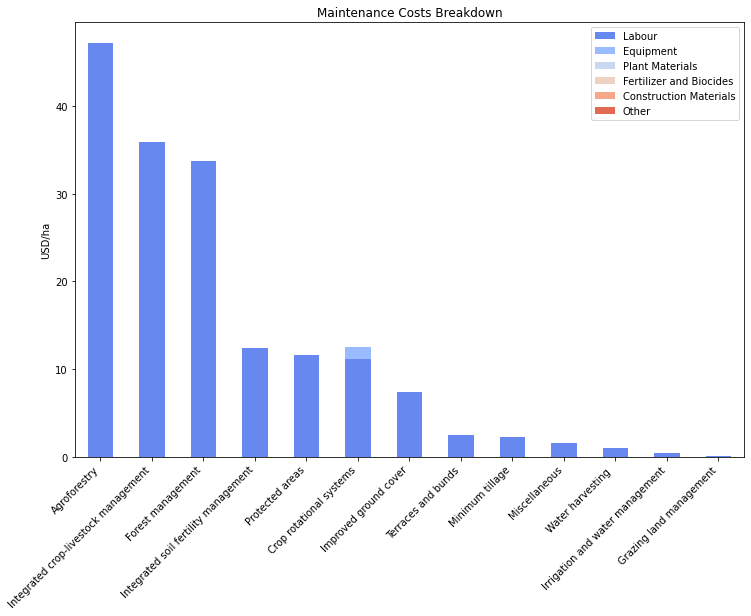

In [69]:
breakdown_median_maint = pd.DataFrame(df.loc[:, ['code', 'slm_group_remapped', 'labour_maint_per_ha', 'equipment_maint_per_ha', 'plant_maint_per_ha', 'fertilizer_maint_per_ha', 'construction_maint_per_ha', 'other_maint_per_ha']].groupby('slm_group_remapped').median()).sort_values(by='labour_maint_per_ha', ascending=False)
breakdown_median_maint.rename({'labour_maint_per_ha': 'Labour', 'equipment_maint_per_ha': 'Equipment', 'plant_maint_per_ha': 'Plant Materials', 'fertilizer_maint_per_ha': 'Fertilizer and Biocides', 'construction_maint_per_ha': 'Construction Materials', 'other_maint_per_ha': 'Other'}, axis=1, inplace=True)
color= sns.color_palette("coolwarm",6)
breakdown_median_maint.plot.bar(stacked=True, color=color)
plt.ylabel('USD/ha')
plt.xlabel('')
plt.title('Maintenance Costs Breakdown')
plt.xticks(rotation=45, ha="right")
# plt.savefig('Report/Figures/maintMedianBreakdownBySLMGroup.png', bbox_inches = "tight")
# print(breakdown_median_maint.to_latex())
breakdown_median_maint


## Production Benefits by SLM Group


socio_economic_production_benefits,Very negative (-50-100%),Negative (-20-50%),Slightly negative (-5-20%),Negligible impact (-5-+5%),Slightly positive (+5-20%),Positive (+20-50%),Very positive (+50-100%)
slm_group_remapped,,,,,,,
Agroforestry,0.00,0.00,0.01,0.08,0.13,0.52,0.25
Crop rotational systems,0.00,0.00,0.03,0.08,0.15,0.54,0.21
Forest management,0.00,0.02,0.02,0.02,0.23,0.45,0.25
Grazing land management,0.04,0.00,0.00,0.07,0.22,0.56,0.11
Improved ground cover,0.00,0.01,0.05,0.11,0.12,0.50,0.21
Integrated crop-livestock management,0.00,0.00,0.00,0.08,0.42,0.42,0.08
Integrated soil fertility management,0.00,0.00,0.00,0.09,0.18,0.36,0.36
Irrigation and water management,0.00,0.00,0.00,0.21,0.17,0.48,0.14
Minimum tillage,0.00,0.00,0.00,0.16,0.26,0.21,0.37


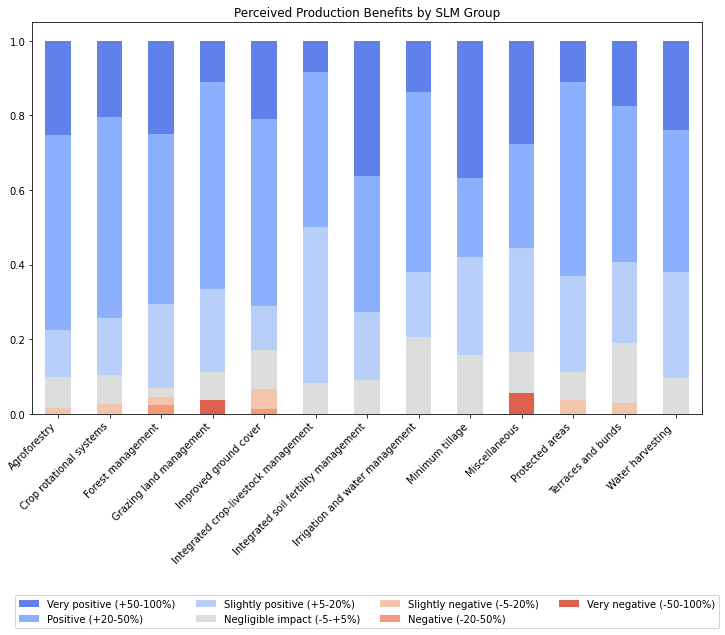

In [70]:
pd.options.display.float_format = '{:,.2f}'.format
production = pd.crosstab(df['slm_group_remapped'], df['socio_economic_production_benefits'], normalize='index')
benefits_list = [
    'Very negative (-50-100%)',
    'Negative (-20-50%)',
    'Slightly negative (-5-20%)',
    'Negligible impact (-5-+5%)',
    'Slightly positive (+5-20%)',
    'Positive (+20-50%)',
    'Very positive (+50-100%)',
]
production = production.reindex(benefits_list, axis='columns')
color= sns.color_palette("coolwarm_r", 7)
ax = production.plot.bar(stacked=True, color=color, legend=False)
plt.xticks(rotation=45, ha="right")
plt.title('Perceived Production Benefits by SLM Group')
plt.xlabel('')
plt.ylabel('')
handles, labels = ax.get_legend_handles_labels()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(reversed(handles), reversed(labels), loc='upper center', bbox_to_anchor=(0.5, -0.45),
          fancybox=True, shadow=False, ncol=4)


# plt.savefig('Report/Figures/productionBenefitsSLMGroup.png', bbox_inches = "tight")
production


## Water Benefits by SLM Group

socio_economic_water_benefits,Very negative (-50-100%),Negative (-20-50%),Slightly negative (-5-20%),Negligible impact (-5-+5%),Slightly positive (+5-20%),Positive (+20-50%),Very positive (+50-100%)
slm_group_remapped,,,,,,,
Agroforestry,0.11,0.11,0.00,0.11,0.26,0.42,0.00
Crop rotational systems,0.00,0.09,0.00,0.27,0.36,0.27,0.00
Forest management,0.09,0.18,0.00,0.36,0.27,0.00,0.09
Grazing land management,0.00,0.12,0.00,0.38,0.00,0.25,0.25
Improved ground cover,0.00,0.06,0.06,0.11,0.44,0.28,0.06
Integrated crop-livestock management,0.00,0.00,0.00,0.17,0.33,0.33,0.17
Irrigation and water management,0.00,0.00,0.07,0.29,0.07,0.14,0.43
Miscellaneous,0.50,0.50,0.00,0.00,0.00,0.00,0.00
Protected areas,0.00,0.00,0.00,0.00,1.00,0.00,0.00


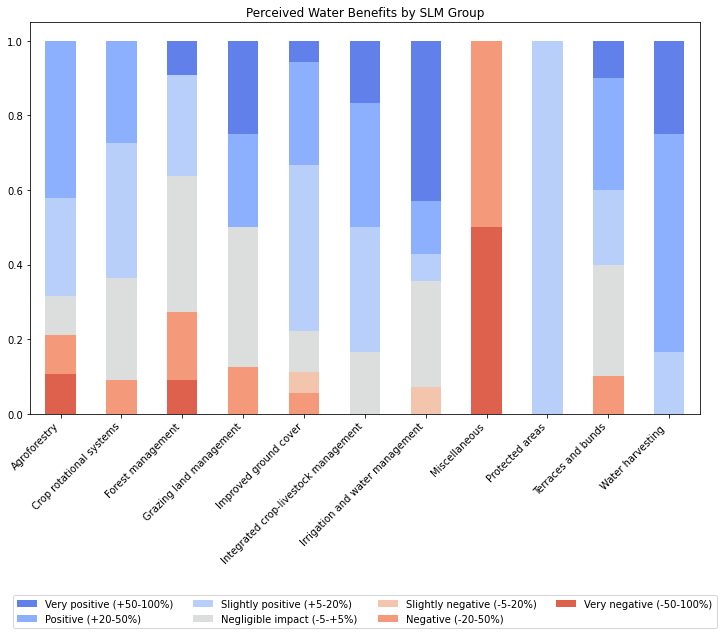

In [71]:
pd.options.display.float_format = '{:,.2f}'.format
water = pd.crosstab(df['slm_group_remapped'], df['socio_economic_water_benefits'], normalize='index')
benefits_list = [
    'Very negative (-50-100%)',
    'Negative (-20-50%)',
    'Slightly negative (-5-20%)',
    'Negligible impact (-5-+5%)',
    'Slightly positive (+5-20%)',
    'Positive (+20-50%)',
    'Very positive (+50-100%)',
]
water = water.reindex(benefits_list, axis='columns')
color= sns.color_palette("coolwarm_r", 7)
ax = water.plot.bar(stacked=True, color=color, legend=False)
plt.xticks(rotation=45, ha="right")
plt.title('Perceived Water Benefits by SLM Group')
plt.xlabel('')
plt.ylabel('')
handles, labels = ax.get_legend_handles_labels()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(reversed(handles), reversed(labels), loc='upper center', bbox_to_anchor=(0.5, -0.45),
          fancybox=True, shadow=False, ncol=4)


# plt.savefig('Report/Figures/waterBenefitsSLMGroup.png', bbox_inches = "tight")
water


## Income benfits by SLM Group

socio_economic_income_benefits,Very negative (-50-100%),Negative (-20-50%),Slightly negative (-5-20%),Negligible impact (-5-+5%),Slightly positive (+5-20%),Positive (+20-50%),Very positive (+50-100%)
slm_group_remapped,,,,,,,
Agroforestry,0.00,0.03,0.09,0.26,0.16,0.39,0.07
Crop rotational systems,0.00,0.12,0.15,0.06,0.21,0.44,0.03
Forest management,0.00,0.11,0.03,0.21,0.13,0.37,0.16
Grazing land management,0.00,0.00,0.05,0.11,0.21,0.53,0.11
Improved ground cover,0.00,0.06,0.11,0.14,0.14,0.31,0.23
Integrated crop-livestock management,0.00,0.09,0.09,0.18,0.36,0.27,0.00
Integrated soil fertility management,0.00,0.05,0.16,0.26,0.05,0.21,0.26
Irrigation and water management,0.00,0.05,0.00,0.27,0.18,0.32,0.18
Minimum tillage,0.00,0.00,0.06,0.24,0.24,0.24,0.24


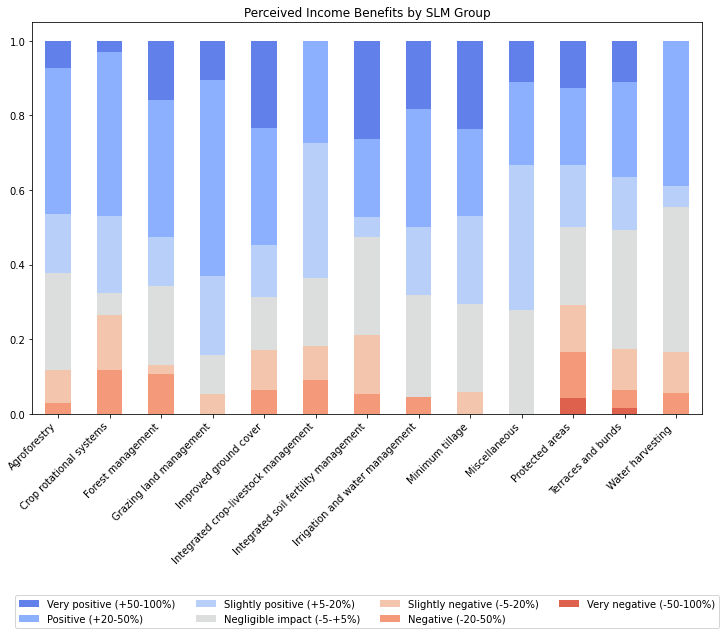

In [72]:
pd.options.display.float_format = '{:,.2f}'.format
income = pd.crosstab(df['slm_group_remapped'], df['socio_economic_income_benefits'], normalize='index')
benefits_list = [
    'Very negative (-50-100%)',
    'Negative (-20-50%)',
    'Slightly negative (-5-20%)',
    'Negligible impact (-5-+5%)',
    'Slightly positive (+5-20%)',
    'Positive (+20-50%)',
    'Very positive (+50-100%)',
]
income = income.reindex(benefits_list, axis='columns')
color= sns.color_palette("coolwarm_r", 7)
ax = income.plot.bar(stacked=True, color=color, legend=False)
plt.xticks(rotation=45, ha="right")
plt.title('Perceived Income Benefits by SLM Group')
plt.xlabel('')
plt.ylabel('')
handles, labels = ax.get_legend_handles_labels()

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(reversed(handles), reversed(labels), loc='upper center', bbox_to_anchor=(0.5, -0.45),
          fancybox=True, shadow=False, ncol=4)


# plt.savefig('Report/Figures/incomeBenefitsSLMGroup.png', bbox_inches = "tight")
income


## Cultural Benefits by SLM Group


socio_cultural_benefits,Very negative (-50-100%),Negative (-20-50%),Slightly negative (-5-20%),Negligible impact (-5-+5%),Slightly positive (+5-20%),Positive (+20-50%),Very positive (+50-100%)
slm_group_remapped,,,,,,,
Agroforestry,NaN,0.01,0.00,0.16,0.19,0.49,0.15
Crop rotational systems,NaN,0.00,0.00,0.03,0.26,0.52,0.19
Forest management,NaN,0.02,0.02,0.09,0.27,0.41,0.18
Grazing land management,NaN,0.00,0.00,0.00,0.21,0.63,0.16
Improved ground cover,NaN,0.01,0.01,0.07,0.24,0.44,0.23
Integrated crop-livestock management,NaN,0.00,0.00,0.00,0.33,0.17,0.50
Integrated soil fertility management,NaN,0.00,0.00,0.24,0.06,0.47,0.24
Irrigation and water management,NaN,0.00,0.00,0.19,0.11,0.52,0.19
Minimum tillage,NaN,0.00,0.00,0.13,0.33,0.20,0.33


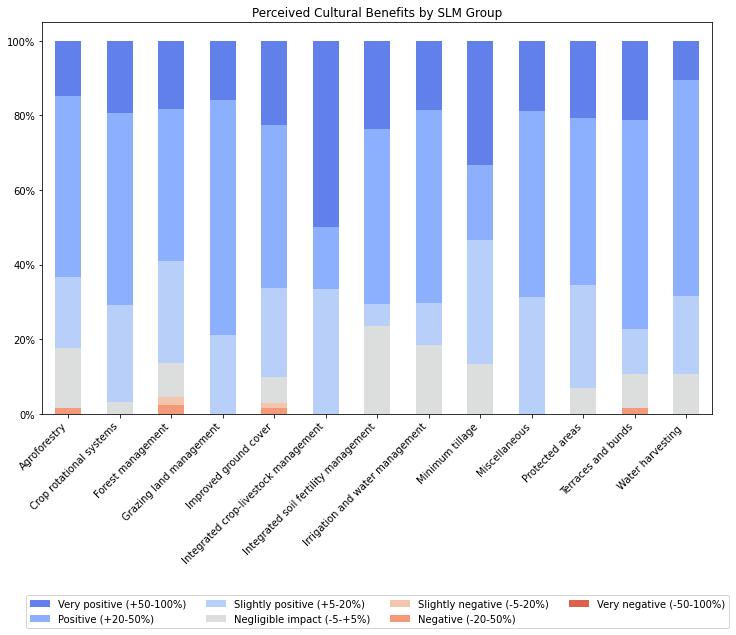

In [73]:

pd.options.display.float_format = '{:,.2f}'.format
cultural = pd.crosstab(df['slm_group_remapped'], df['socio_cultural_benefits'], normalize='index')
benefits_list = [
    'Very negative (-50-100%)',
    'Negative (-20-50%)',
    'Slightly negative (-5-20%)',
    'Negligible impact (-5-+5%)',
    'Slightly positive (+5-20%)',
    'Positive (+20-50%)',
    'Very positive (+50-100%)',
]
cultural = cultural.reindex(benefits_list, axis='columns')
color= sns.color_palette("coolwarm_r", 7) ##da812c
# fig, ax = plt.subplots()
ax = cultural.plot.bar(stacked=True, color=color, legend=False)
plt.xticks(rotation=45, ha="right")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
plt.title('Perceived Cultural Benefits by SLM Group')
plt.xlabel('')
plt.ylabel('')
handles, labels = ax.get_legend_handles_labels()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(reversed(handles), reversed(labels), loc='upper center', bbox_to_anchor=(0.5, -0.45),
          fancybox=True, shadow=False, ncol=4)


# plt.savefig('Report/Figures/culturalBenefitsSLMGroup.png', bbox_inches = "tight")
cultural



## Climate and Disaster risk by SLM Group

ecological_climate_disaster_risk_benefits,Very negative (-50-100%),Negative (-20-50%),Slightly negative (-5-20%),Negligible impact (-5-+5%),Slightly positive (+5-20%),Positive (+20-50%),Very positive (+50-100%)
slm_group_remapped,,,,,,,
Agroforestry,NaN,0.00,0.00,0.05,0.34,0.41,0.20
Crop rotational systems,NaN,0.00,0.00,0.21,0.43,0.21,0.14
Forest management,NaN,0.03,0.00,0.14,0.33,0.36,0.14
Grazing land management,NaN,0.19,0.00,0.00,0.19,0.44,0.19
Improved ground cover,NaN,0.11,0.00,0.17,0.19,0.39,0.14
Integrated crop-livestock management,NaN,0.00,0.00,0.00,0.50,0.38,0.12
Integrated soil fertility management,NaN,0.00,0.00,0.17,0.50,0.17,0.17
Irrigation and water management,NaN,0.00,0.00,0.00,0.33,0.44,0.22
Minimum tillage,NaN,0.00,0.00,0.25,0.62,0.12,0.00


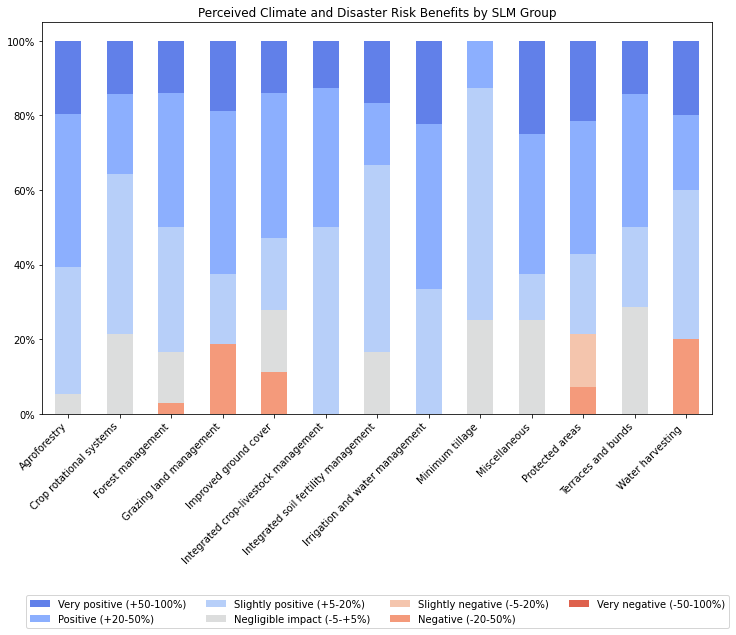

In [74]:
pd.options.display.float_format = '{:,.2f}'.format
climate = pd.crosstab(df['slm_group_remapped'], df['ecological_climate_disaster_risk_benefits'], normalize='index')
benefits_list = [
    'Very negative (-50-100%)',
    'Negative (-20-50%)',
    'Slightly negative (-5-20%)',
    'Negligible impact (-5-+5%)',
    'Slightly positive (+5-20%)',
    'Positive (+20-50%)',
    'Very positive (+50-100%)',
]
climate = climate.reindex(benefits_list, axis='columns')
color= sns.color_palette("coolwarm_r", 7) 

ax = climate.plot.bar(stacked=True, color=color, legend=False)
plt.xticks(rotation=45, ha="right")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
plt.title('Perceived Climate and Disaster Risk Benefits by SLM Group')
plt.xlabel('')
plt.ylabel('')
handles, labels = ax.get_legend_handles_labels()
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(reversed(handles), reversed(labels), loc='upper center', bbox_to_anchor=(0.5, -0.45),
          fancybox=True, shadow=False, ncol=4)


# plt.savefig('Report/Figures/climateBenefitsSLMGroup.png', bbox_inches = "tight")
climate



## Costs by slm group and region

In [75]:
counts = df.loc[
            (df['slm_group_remapped']=='Improved ground cover') |
            (df['slm_group_remapped']=='Agroforestry') |
            (df['slm_group_remapped']=='Terraces and bunds') |
            (df['slm_group_remapped']=='Forest management')
            ] \
        .groupby(['slm_group_remapped', 'Sub-region Name']) \
        .agg(count=('code', 'count'),
             median_total_present_value_25=('total_present_values_2_5_per_ha', 'median'),
             median_est=('4_5_tech_input_est_total_costs_2020_usd_per_ha', 'median'),
             median_est_25=('4_5_tech_input_est_total_costs_2020_usd_per_ha', q25),
             median_est_75=('4_5_tech_input_est_total_costs_2020_usd_per_ha', q75),
             median_maint=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', 'median'),
             median_maint_25=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', q25),
             median_maint_75=('4_7_tech_input_maint_total_costs_2020_usd_per_ha', q75),
             
           ) \
        
counts.insert(counts.columns.get_loc('median_total_present_value_25'), '(%)', (counts['count']/counts['count'].sum() * 100))

counts = counts.rename(columns={'count':'Count',
                         'median_est_25':'Est. Costs (25%)',
                         'median_est': 'Est. Costs (50%)',
                         'median_est_75':'Est. Costs (75%)',
                         'median_maint_25':'Maint. Costs (25%)',
                         'median_maint': 'Maint. Costs (50%)',
                         'median_maint_75':'Maint. Costs (75%)',
                         'median_total_present_value_25':'Median Total Present Value (2.5%)',
                        }) \
#         .reset_index() \
#         .sort_values(['Count'], ascending=False)
counts

# print(counts.to_latex(index=True))


Count   (%)  \
slm_group_remapped    Sub-region Name                                
Agroforestry          Central Asia                        14  4.93   
                      Eastern Asia                         3  1.06   
                      Latin America and the Caribbean      8  2.82   
                      Northern Africa                      3  1.06   
                      South-eastern Asia                  13  4.58   
                      Southern Asia                        4  1.41   
                      Southern Europe                      1  0.35   
                      Sub-Saharan Africa                  28  9.86   
                      Western Europe                       1  0.35   
Forest management     Central Asia                         5  1.76   
                      Latin America and the Caribbean      5  1.76   
                      Northern Africa                      5  1.76   
                      South-eastern Asia                   4  1.41   
                      Southern Asia                       10  3.52   
                      Southern Europe                      7  2.46   
                      Sub-Saharan Africa                  13  4.58   
                      Western Asia                         1  0.35   
Improved ground cover Australia and New Zealand            1  0.35   
                      Central Asia                        14  4.93   
                      Eastern Asia                         2  0.70   
                      Eastern Europe                       1  0.35   
                      Latin America and the Caribbean      4  1.41   
                      Northern Africa                      4  1.41   
                      Northern Europe                      2  0.70   
                      South-eastern Asia                   3  1.06   
                      Southern Asia                        9  3.17   
                      Southern Europe                     12  4.23   
                      Sub-Saharan Africa                  34 11.97   
                      Western Asia                         3  1.06   
Terraces and bunds    Central Asia                         1  0.35   
                      Eastern Asia                         1  0.35   
                      Latin America and the Caribbean      5  1.76   
                      Northern Africa                      1  0.35   
                      South-eastern Asia                   7  2.46   
                      Southern Asia                       11  3.87   
                      Southern Europe                      1  0.35   
                      Sub-Saharan Africa                  40 14.08   
                      Western Asia                         3  1.06   

                                                       Median Total Present Value (2.5%)  \
slm_group_remapped    Sub-region Name                                                      
Agroforestry          Central Asia                                                994.27   
                      Eastern Asia                                                531.09   
                      Latin America and the Caribbean                           3,900.29   
                      Northern Africa                                           6,331.73   
                      South-eastern Asia                                        2,393.30   
                      Southern Asia                                             2,766.67   
                      Southern Europe                                          13,049.56   
                      Sub-Saharan Africa                                          371.51   
                      Western Europe                                            4,273.16   
Forest management     Central Asia                                              2,844.36   
                      Latin America and the Caribbean                           1,192.81   
                      Northern Africa                     